In [55]:
import numpy as np
import numpy.linalg as la 
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from tqdm import trange

plt.rcParams['figure.figsize'] = [10,8]
plt.rcParams.update({'font.size': 25})
%config InlineBackend.figure_format = 'retina'
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [6]:
dataf = pd.read_csv('premier_league_2013_2014.dat', sep=',', header=None)
dataf.columns = ['goals_home', 'goals_away', 'home_team', 'away_team']
dataf.head()

,goals_home,goals_away,home_team,away_team
0,1.0,3.0,0.0,1.0
1,2.0,0.0,0.0,2.0
2,0.0,0.0,0.0,3.0
3,2.0,0.0,0.0,4.0
4,1.0,1.0,0.0,5.0


In [38]:
def enforce_corner_constraint(theta, n_teams):
    theta[0] = theta[n_teams] = 0
    return theta

def propose_samples(current, sigma):
    I = np.eye(current.shape[0])
    proposal = np.random.multivariate_normal(current, cov=I*sigma**2)
    return proposal

def compute_hyper_prior_probabilities(eta):
    tau1 = 0.0001
    alpha = beta = 0.1

    mu_attack_logprob = st.norm(0, 1/np.sqrt(tau1)).logpdf(eta[0])
    mu_defense_logprob = st.norm(0, 1/np.sqrt(tau1)).logpdf(eta[1])
    tau_attack_logprob = st.gamma(alpha, scale=1/beta).logpdf(eta[2])
    tau_defense_logprob = st.gamma(alpha, scale=1/beta).logpdf(eta[3])

    eta_logprob = mu_attack_logprob + mu_defense_logprob + tau_attack_logprob + tau_defense_logprob
    return eta_logprob

def compute_prior_probabilities(eta, theta, n_teams):
    tau0 = 0.0001

    mu_attack = eta[0]
    mu_defense = eta[1]
    tau_attack = eta[2]
    tau_defense = eta[3]
    
    home = theta[-1]
    attack = theta[:n_teams]
    defense = theta[n_teams:-1]

    home_logprob = st.norm(0, 1/np.sqrt(tau0)).logpdf(home)
    attack_logprob = st.norm(mu_attack, 1/np.sqrt(tau_attack)).logpdf(attack)
    defense_logprob = st.norm(mu_defense, 1/np.sqrt(tau_defense)).logpdf(defense)

    theta_prob = home_logprob + np.sum(attack_logprob + defense_logprob)
    return theta_prob

def compute_likelihood(theta, n_teams, dataf):
    
    goals_home = dataf['goals_home'].values.astype(int)
    goals_away = dataf['goals_away'].values.astype(int)
    home_team = dataf['home_team'].values.astype(int)
    away_team = dataf['away_team'].values.astype(int)

    home = theta[-1]
    attack = theta[:n_teams]
    defense = theta[n_teams:-1]

    theta_home = np.exp(home + attack[home_team] - defense[away_team])
    theta_away = np.exp(attack[away_team] - defense[home_team])
    
    loglikelihood_home = st.poisson(theta_home).logpmf(goals_home)
    loglikelihood_away = st.poisson(theta_away).logpmf(goals_away)

    loglikelihood = np.sum(loglikelihood_home + loglikelihood_away)
    return loglikelihood

def compute_probabilities(eta, theta, n_teams, dataf):
    eta_logprob = compute_hyper_prior_probabilities(eta)
    theta_logprob = compute_prior_probabilities(eta, theta, n_teams)
    loglikelihood = compute_likelihood(theta, n_teams, dataf)
    logprob = eta_logprob + theta_logprob + loglikelihood
    return logprob

def metropolis_hastings(n_samples, n_teams, sigma, dataf, thinning, burn_in, sample_burn_in=False):

    starting_point = 0.1
    eta_current = np.full(4, starting_point)
    theta_current = enforce_corner_constraint(np.full(1+n_teams*2, starting_point), n_teams)
    samples = []
    rejection = []
    t = 0
    
    if sample_burn_in:
        n_samples = n_samples+(burn_in/thinning)

    while n_samples > len(samples):

        eta_proposal = propose_samples(eta_current, sigma)
        theta_proposal = enforce_corner_constraint(propose_samples(theta_current, sigma), n_teams)

        current_logprob = compute_probabilities(eta_current, theta_current, n_teams, dataf)
        proposal_logprob = compute_probabilities(eta_proposal, theta_proposal, n_teams, dataf)
        acceptance_logprob = proposal_logprob - current_logprob

        u = np.random.uniform()
        if np.log(u) < acceptance_logprob:
            eta_current = eta_proposal.copy()
            theta_current = theta_proposal.copy()
            rejection.append(0)
        else:
            rejection.append(1)

        if t % thinning == 0:
            if sample_burn_in:
                samples.append(theta_current.copy())     
            elif t > burn_in:
                samples.append(theta_current.copy())     

        t += 1   
        print(f'\r{len(samples)} / {n_samples} samples', end='')

    return np.array(samples), np.array(rejection)

In [ ]:
n_samples = 5000
n_teams = 20
sigmas = [0.005, 0.05, 0.5]
thinning = [1, 5, 20, 50]
burn_in = 5000
home_batches = []
rejection_batches = []

In [39]:
for i in range(len(sigmas)):
    for j in range(len(thinning)):

        print(f'\nRunning sigma={sigmas[i]} and thinning={thinning[j]}')
        samples, rejection = metropolis_hastings(n_samples, n_teams, sigmas[i], dataf, thinning[j], burn_in, sample_burn_in=True)
        homes = samples[:,-1]
        # home_batches.append(samples[:,-1])
        # rejection_batches.append(rejection)

        np.save(f'samples/home_sigma={sigmas[i]}_thinning={thinning[j]}.npy', homes)
        np.save(f'samples/rejection_sigma={sigmas[i]}_thinning={thinning[j]}.npy', rejection)
        
        del homes
        del samples
        del rejection


Running sigma=0.005 and thinning=1
10000 / 10000.0 samples
Running sigma=0.005 and thinning=5
6000 / 6000.0 samples
Running sigma=0.005 and thinning=20
5250 / 5250.0 samples
Running sigma=0.005 and thinning=50
5100 / 5100.0 samples
Running sigma=0.05 and thinning=1
10000 / 10000.0 samples
Running sigma=0.05 and thinning=5
6000 / 6000.0 samples
Running sigma=0.05 and thinning=20
5250 / 5250.0 samples
Running sigma=0.05 and thinning=50
5100 / 5100.0 samples
Running sigma=0.5 and thinning=1
4 / 10000.0 samples

C:\Users\erikn\AppData\Local\Temp\ipykernel_2004\1881268469.py:36: RuntimeWarning: invalid value encountered in sqrt
  defense_logprob = st.norm(mu_defense, 1/np.sqrt(tau_defense)).logpdf(defense)
C:\Users\erikn\AppData\Local\Temp\ipykernel_2004\1881268469.py:35: RuntimeWarning: invalid value encountered in sqrt
  attack_logprob = st.norm(mu_attack, 1/np.sqrt(tau_attack)).logpdf(attack)


10000 / 10000.0 samples
Running sigma=0.5 and thinning=5
6000 / 6000.0 samples
Running sigma=0.5 and thinning=20
5250 / 5250.0 samples
Running sigma=0.5 and thinning=50
5100 / 5100.0 samples

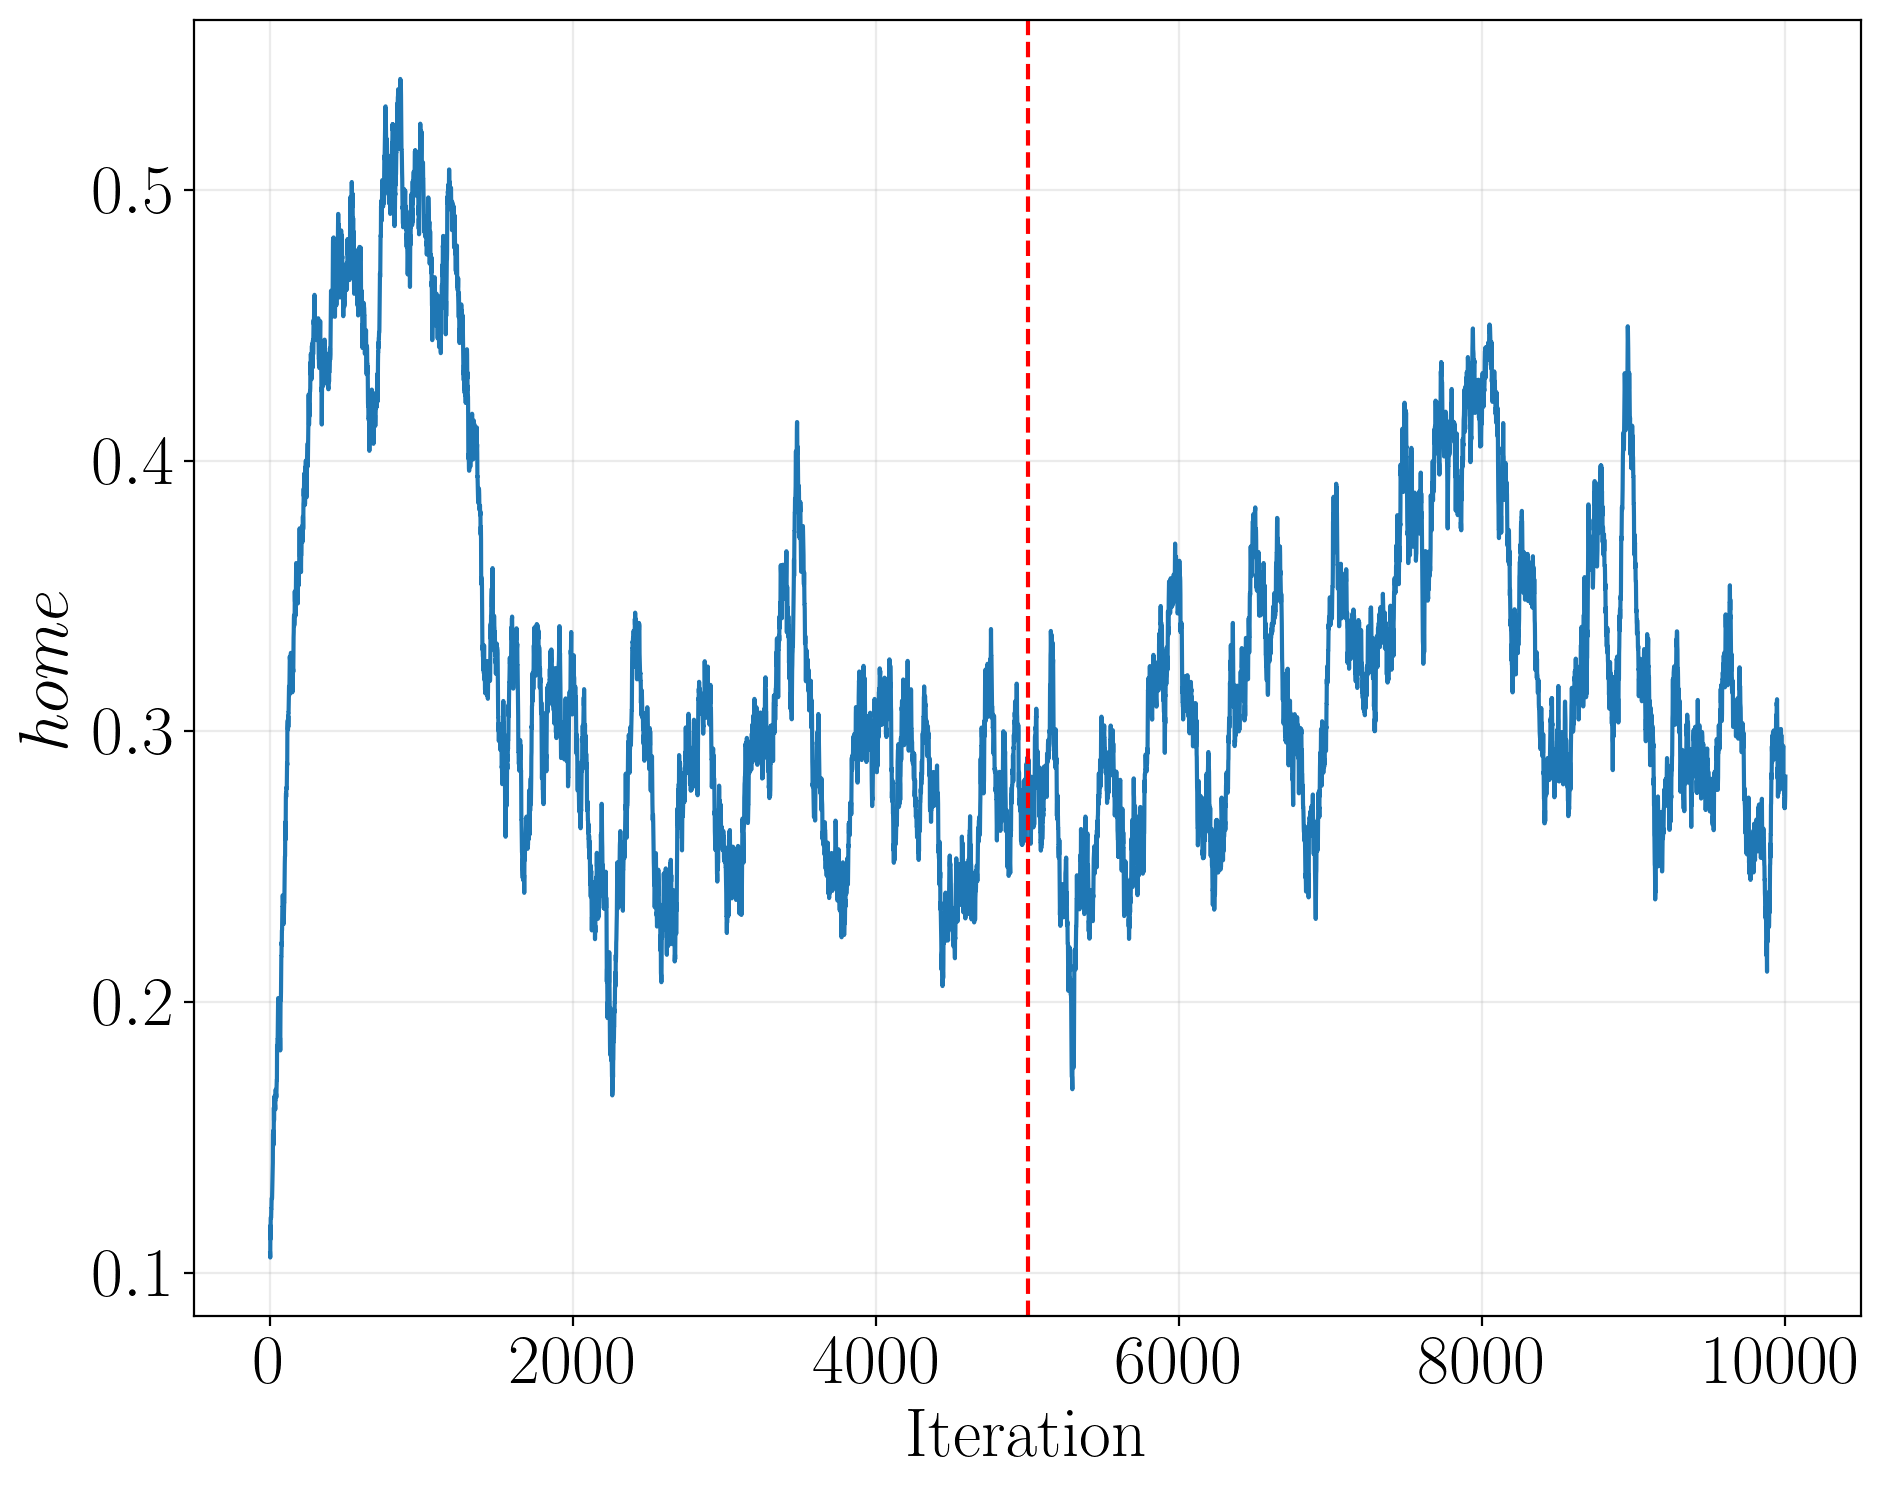

Rejection rate: sigma=0.005, thinning=1: 0.108


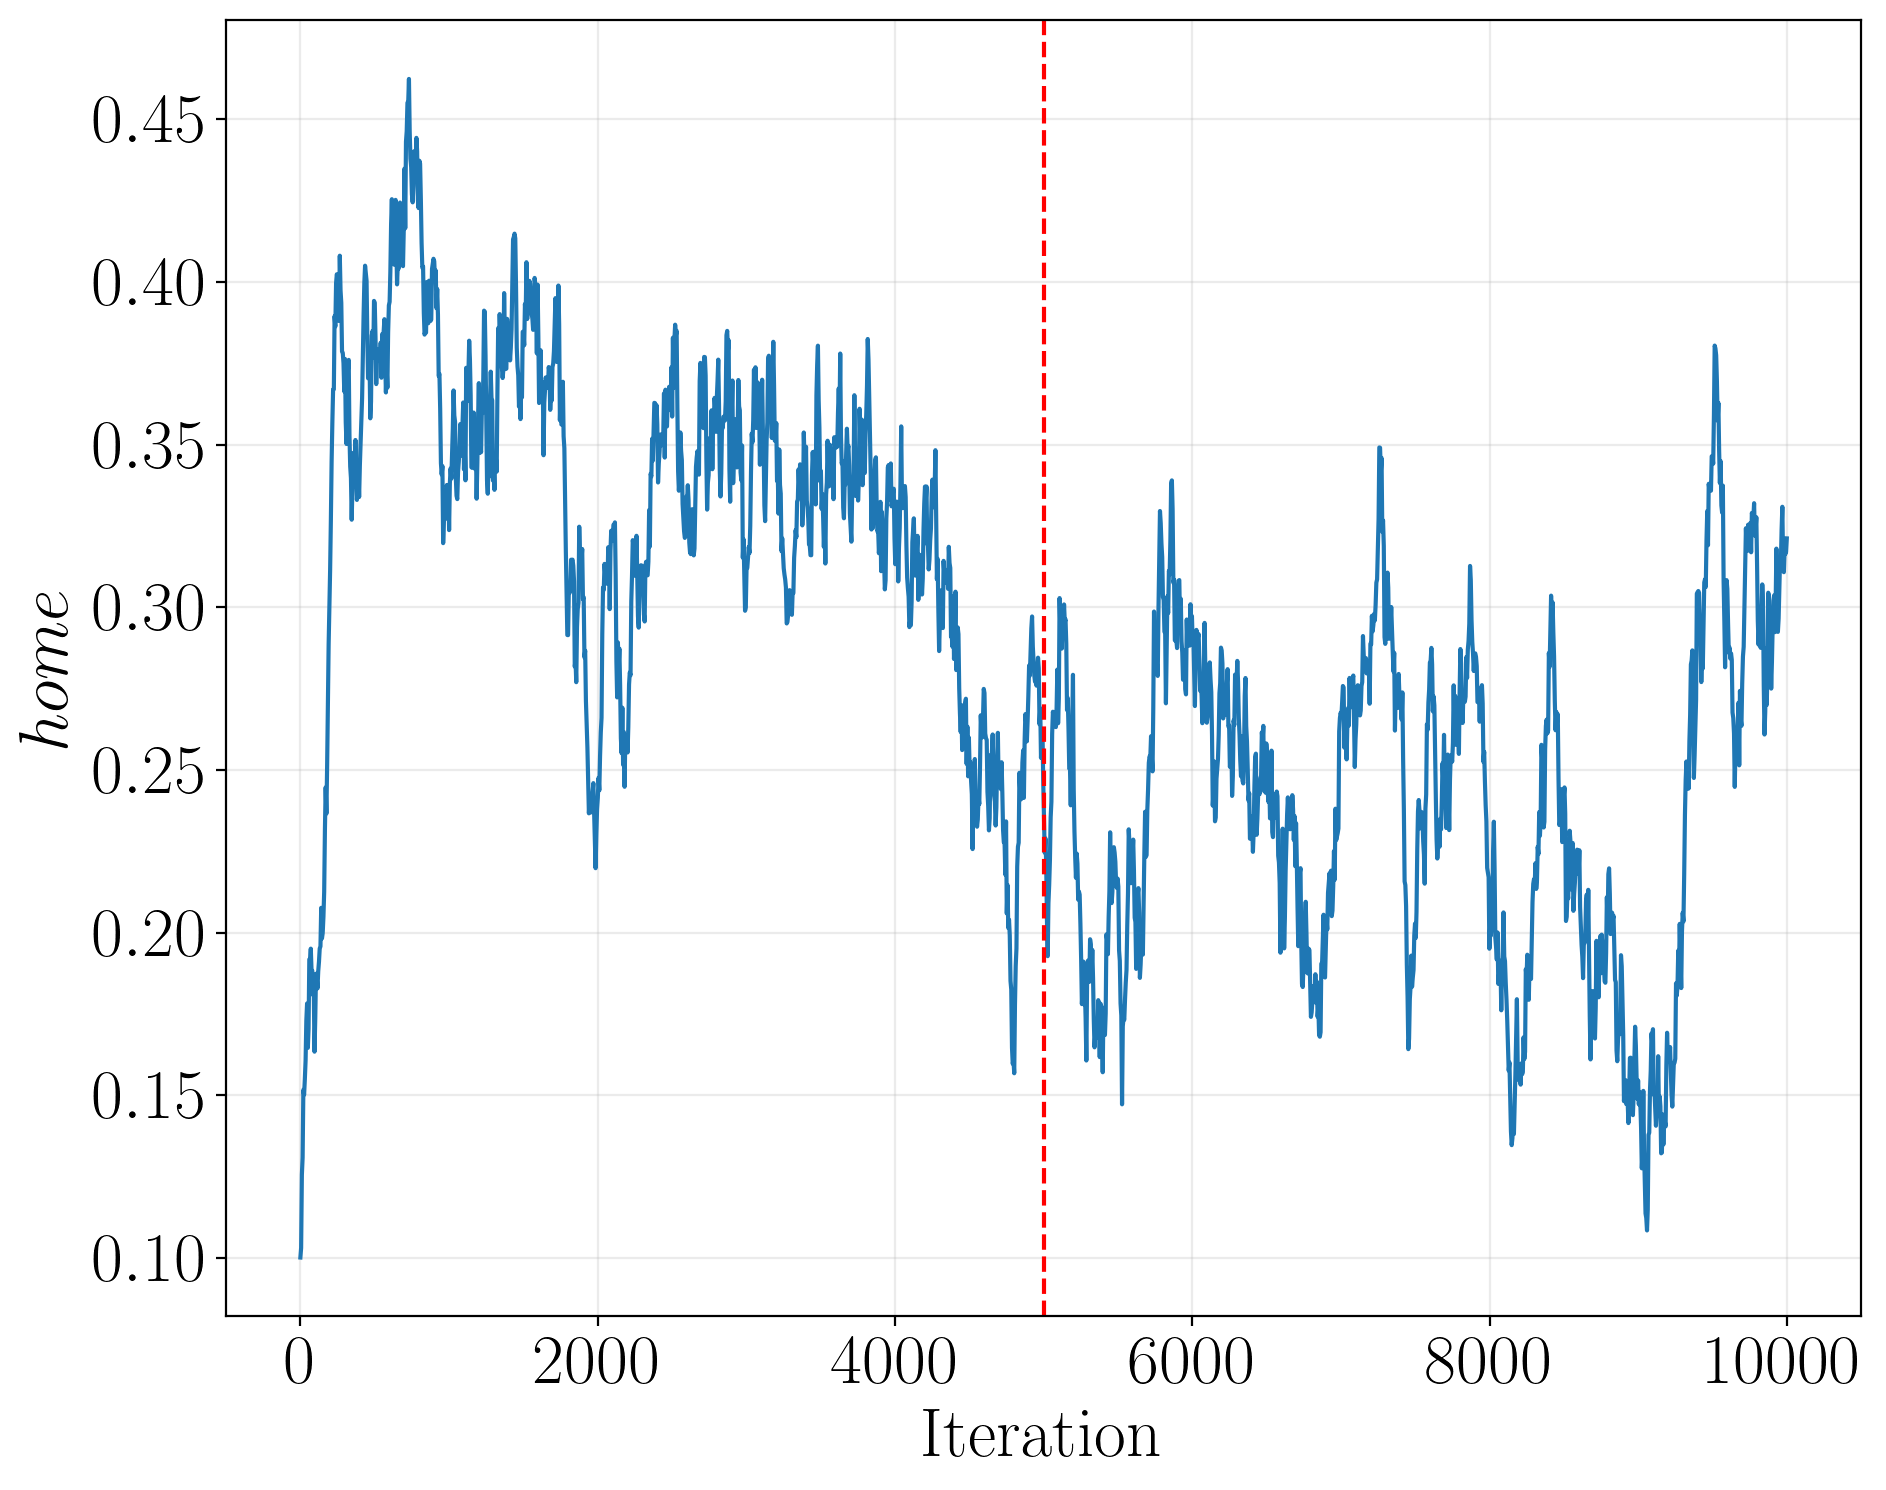

Rejection rate: sigma=0.005, thinning=5: 0.0995


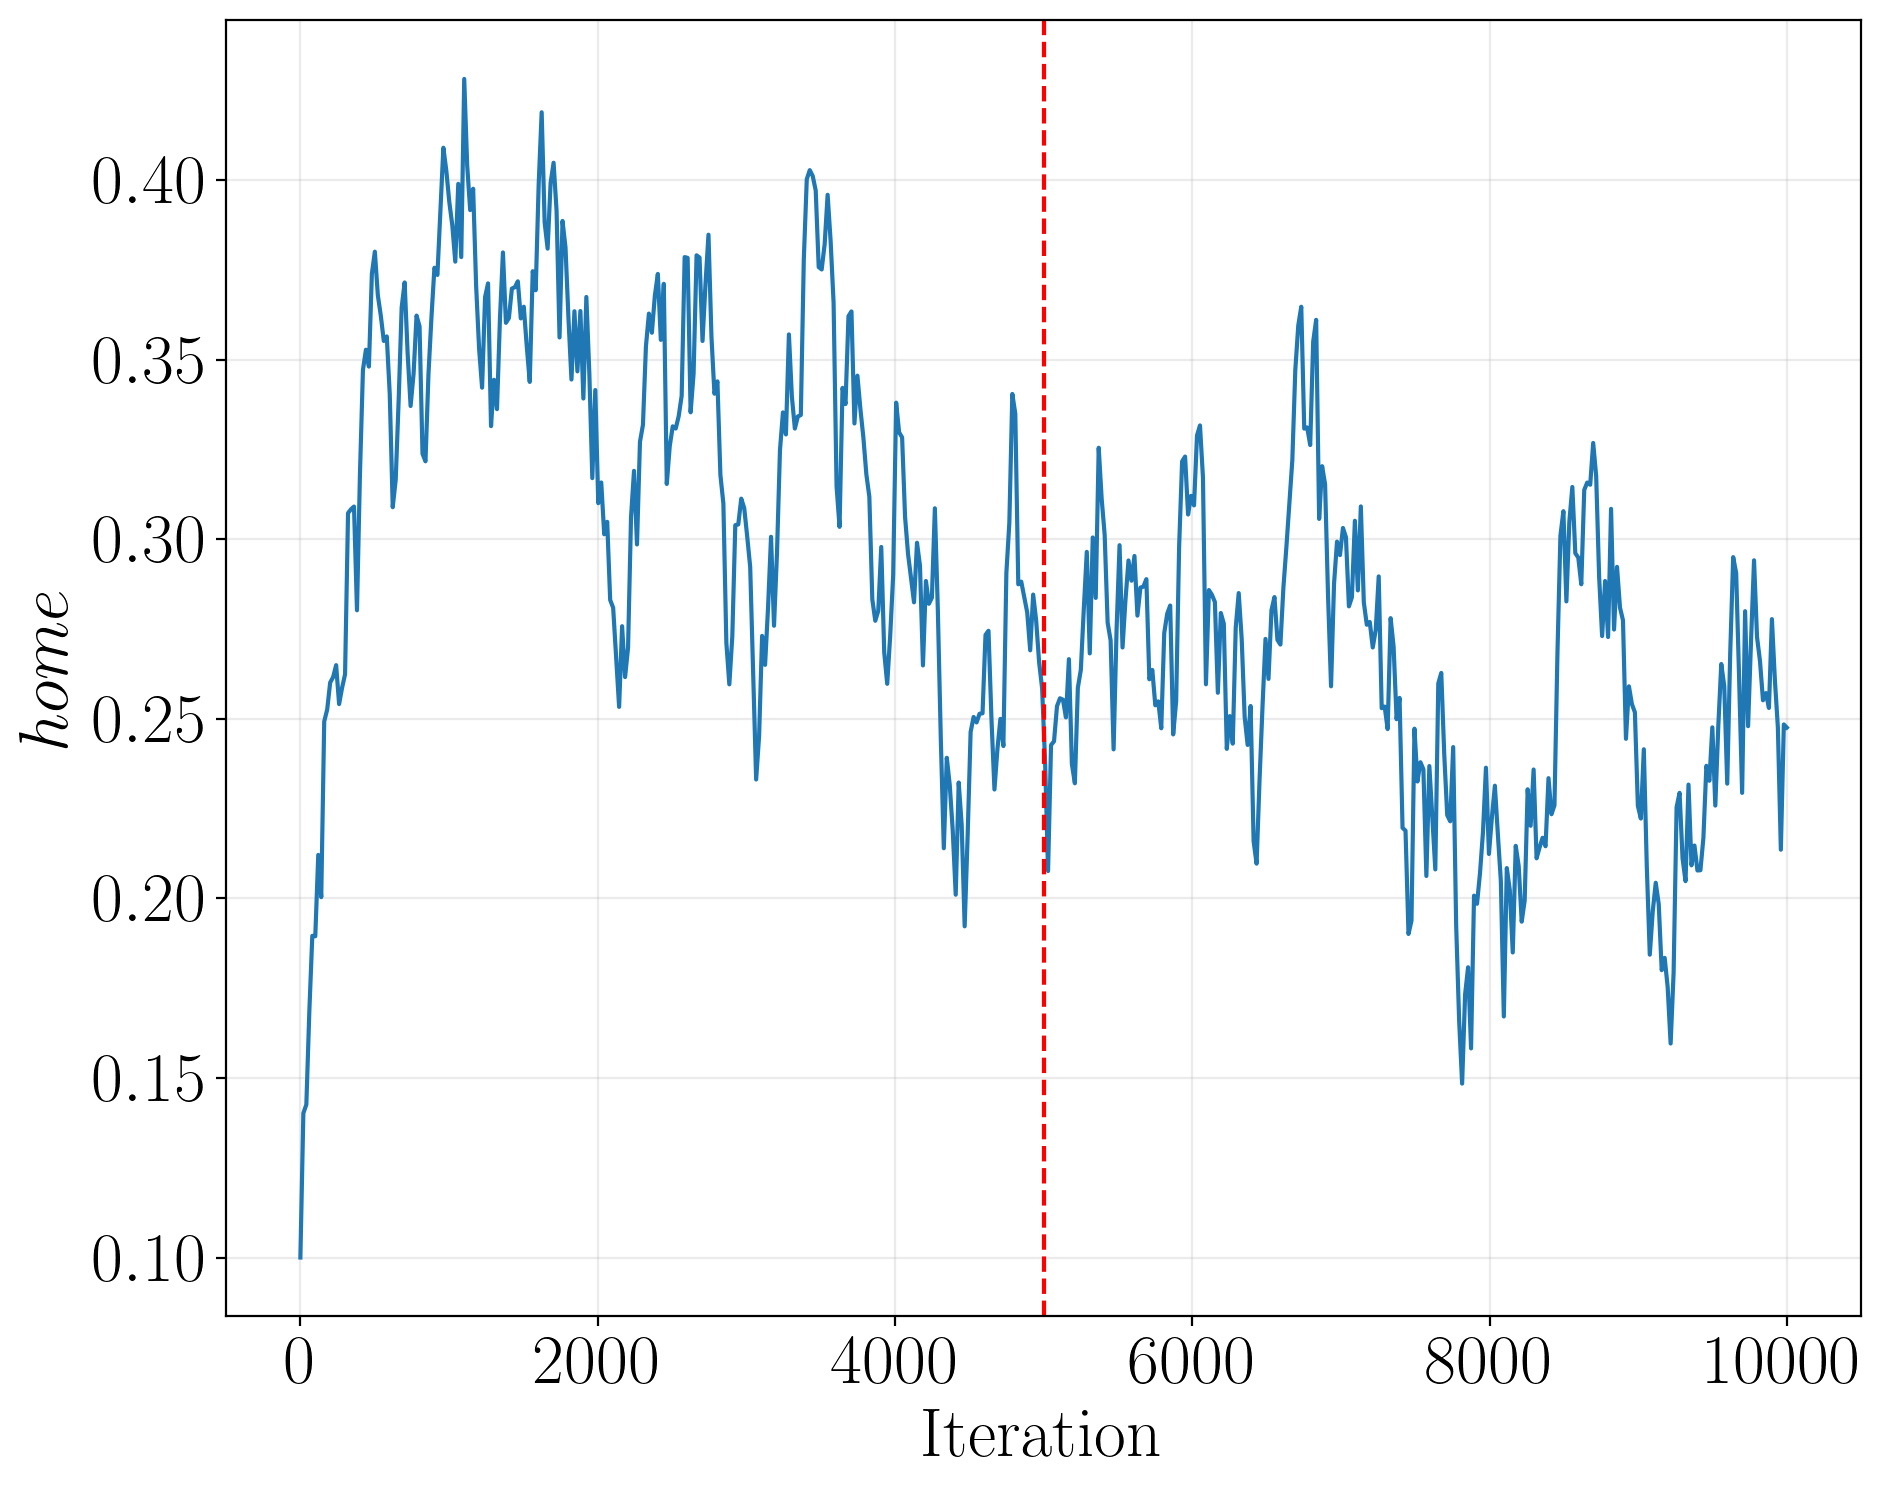

Rejection rate: sigma=0.005, thinning=20: 0.1039


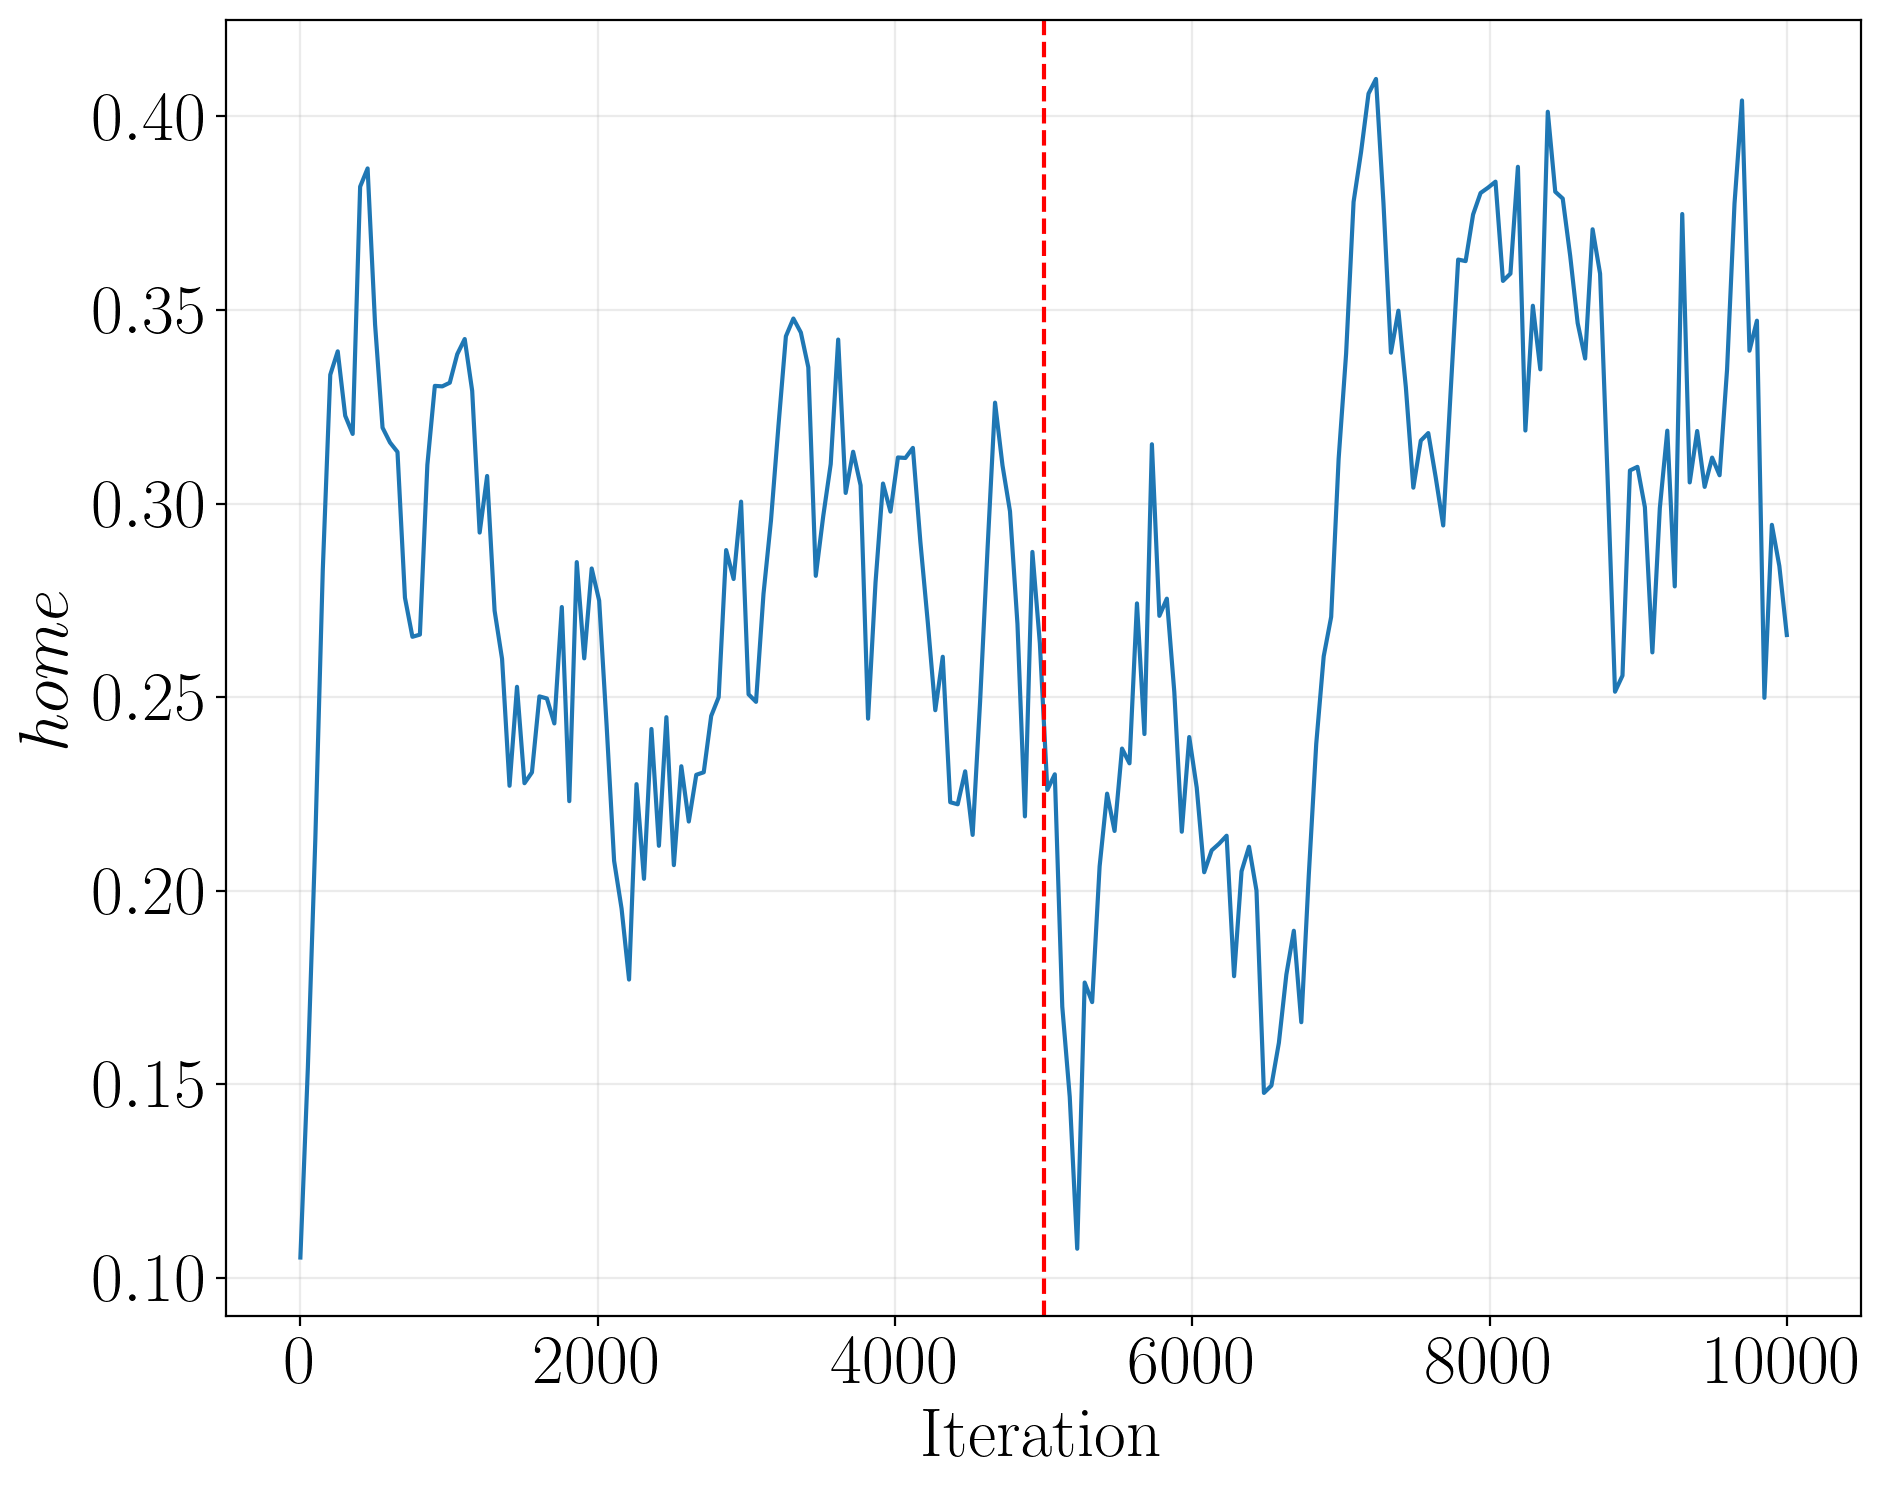

Rejection rate: sigma=0.005, thinning=50: 0.1038


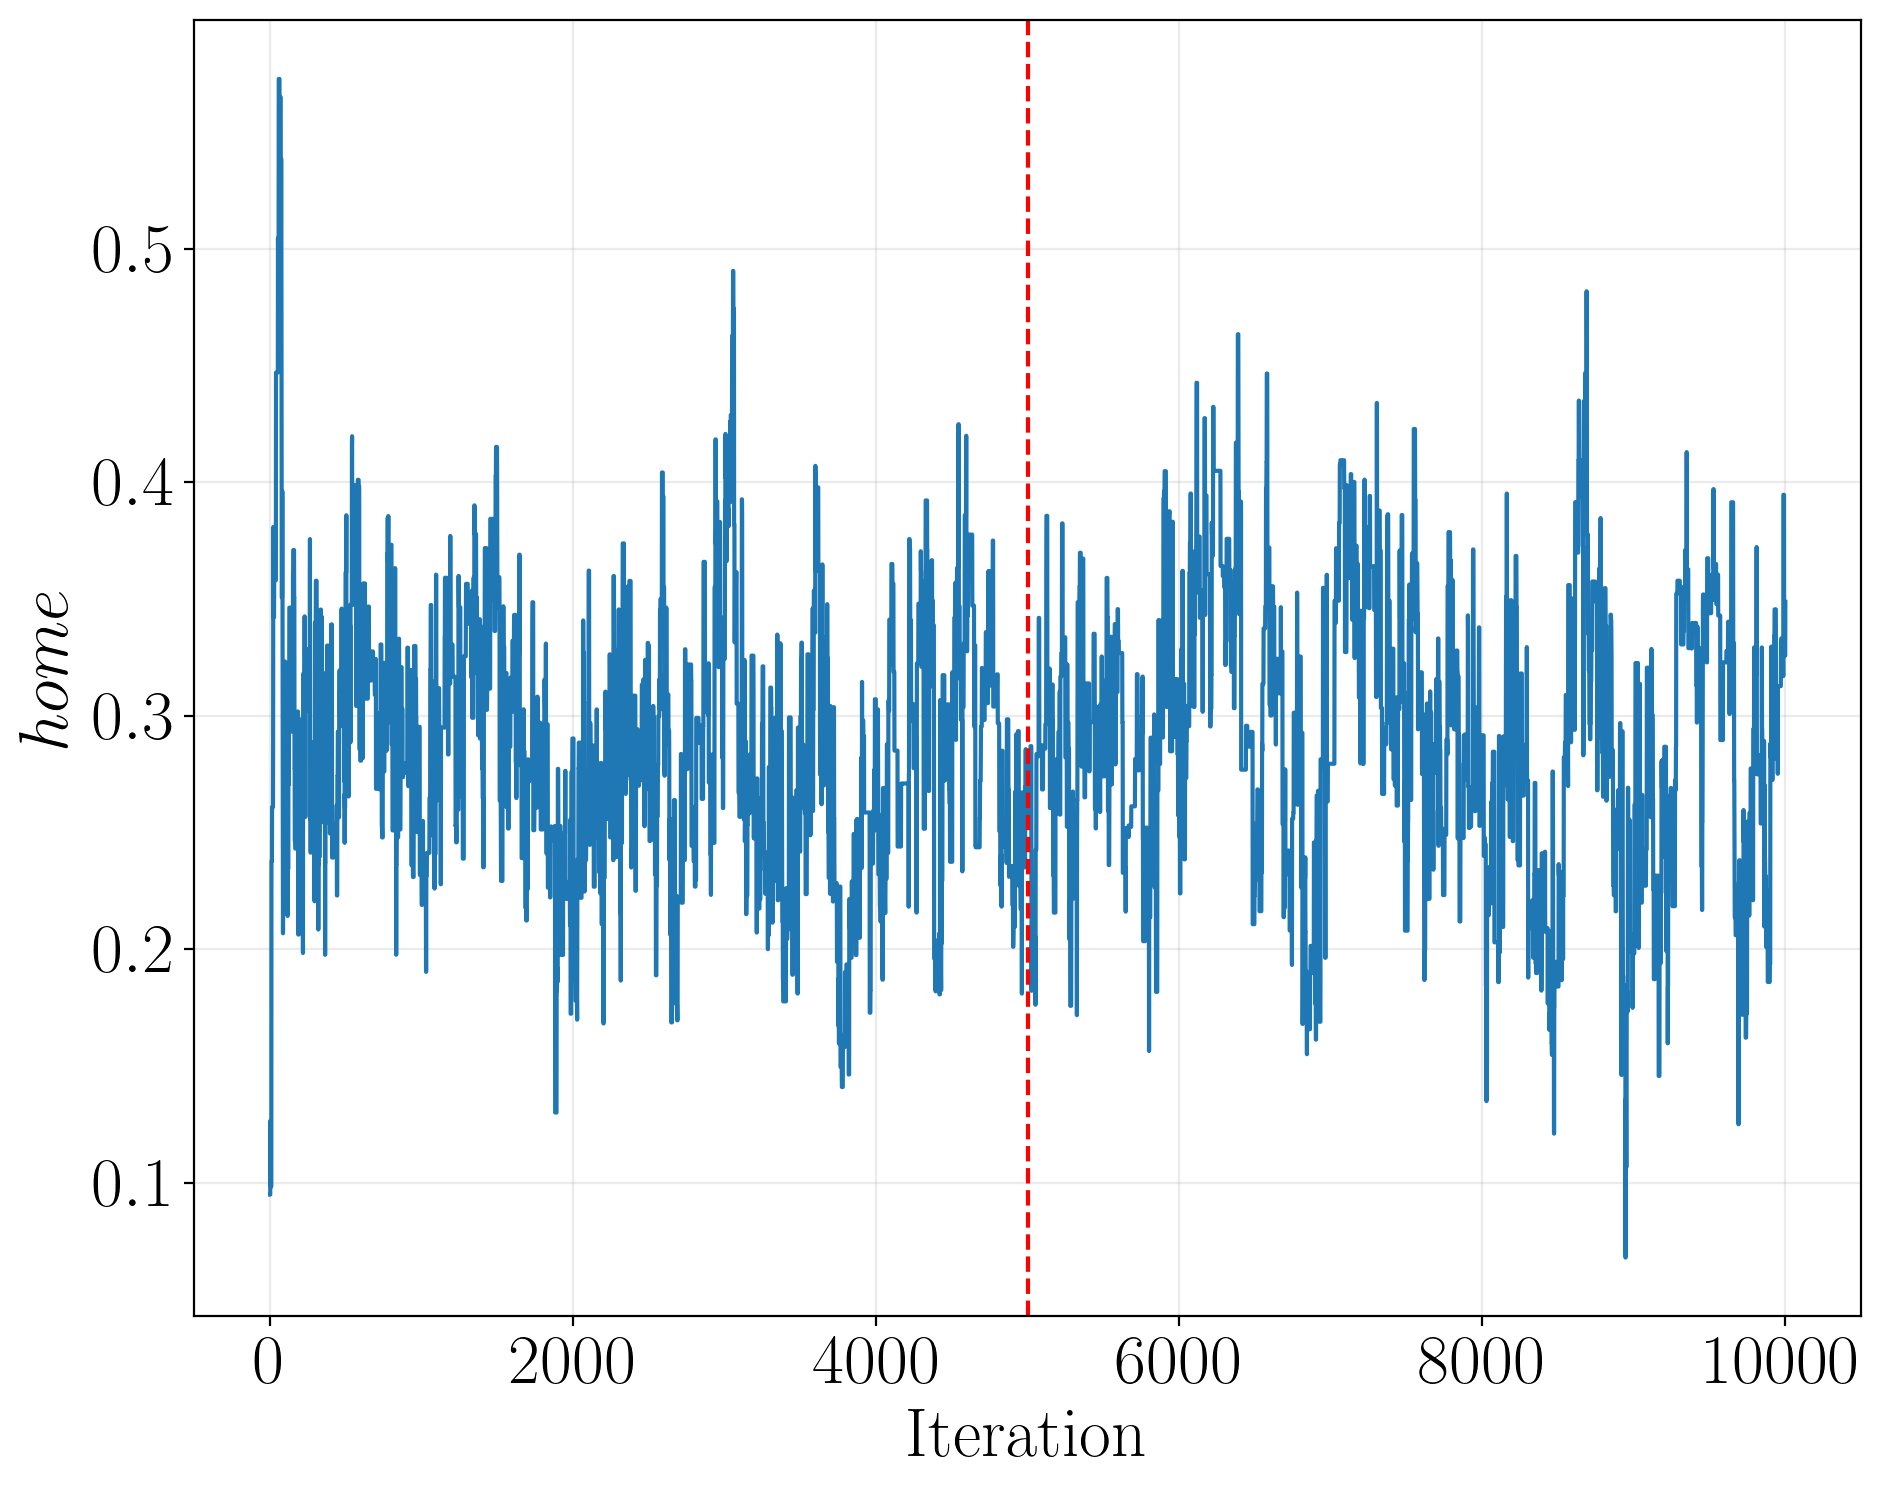

Rejection rate: sigma=0.05, thinning=1: 0.8196


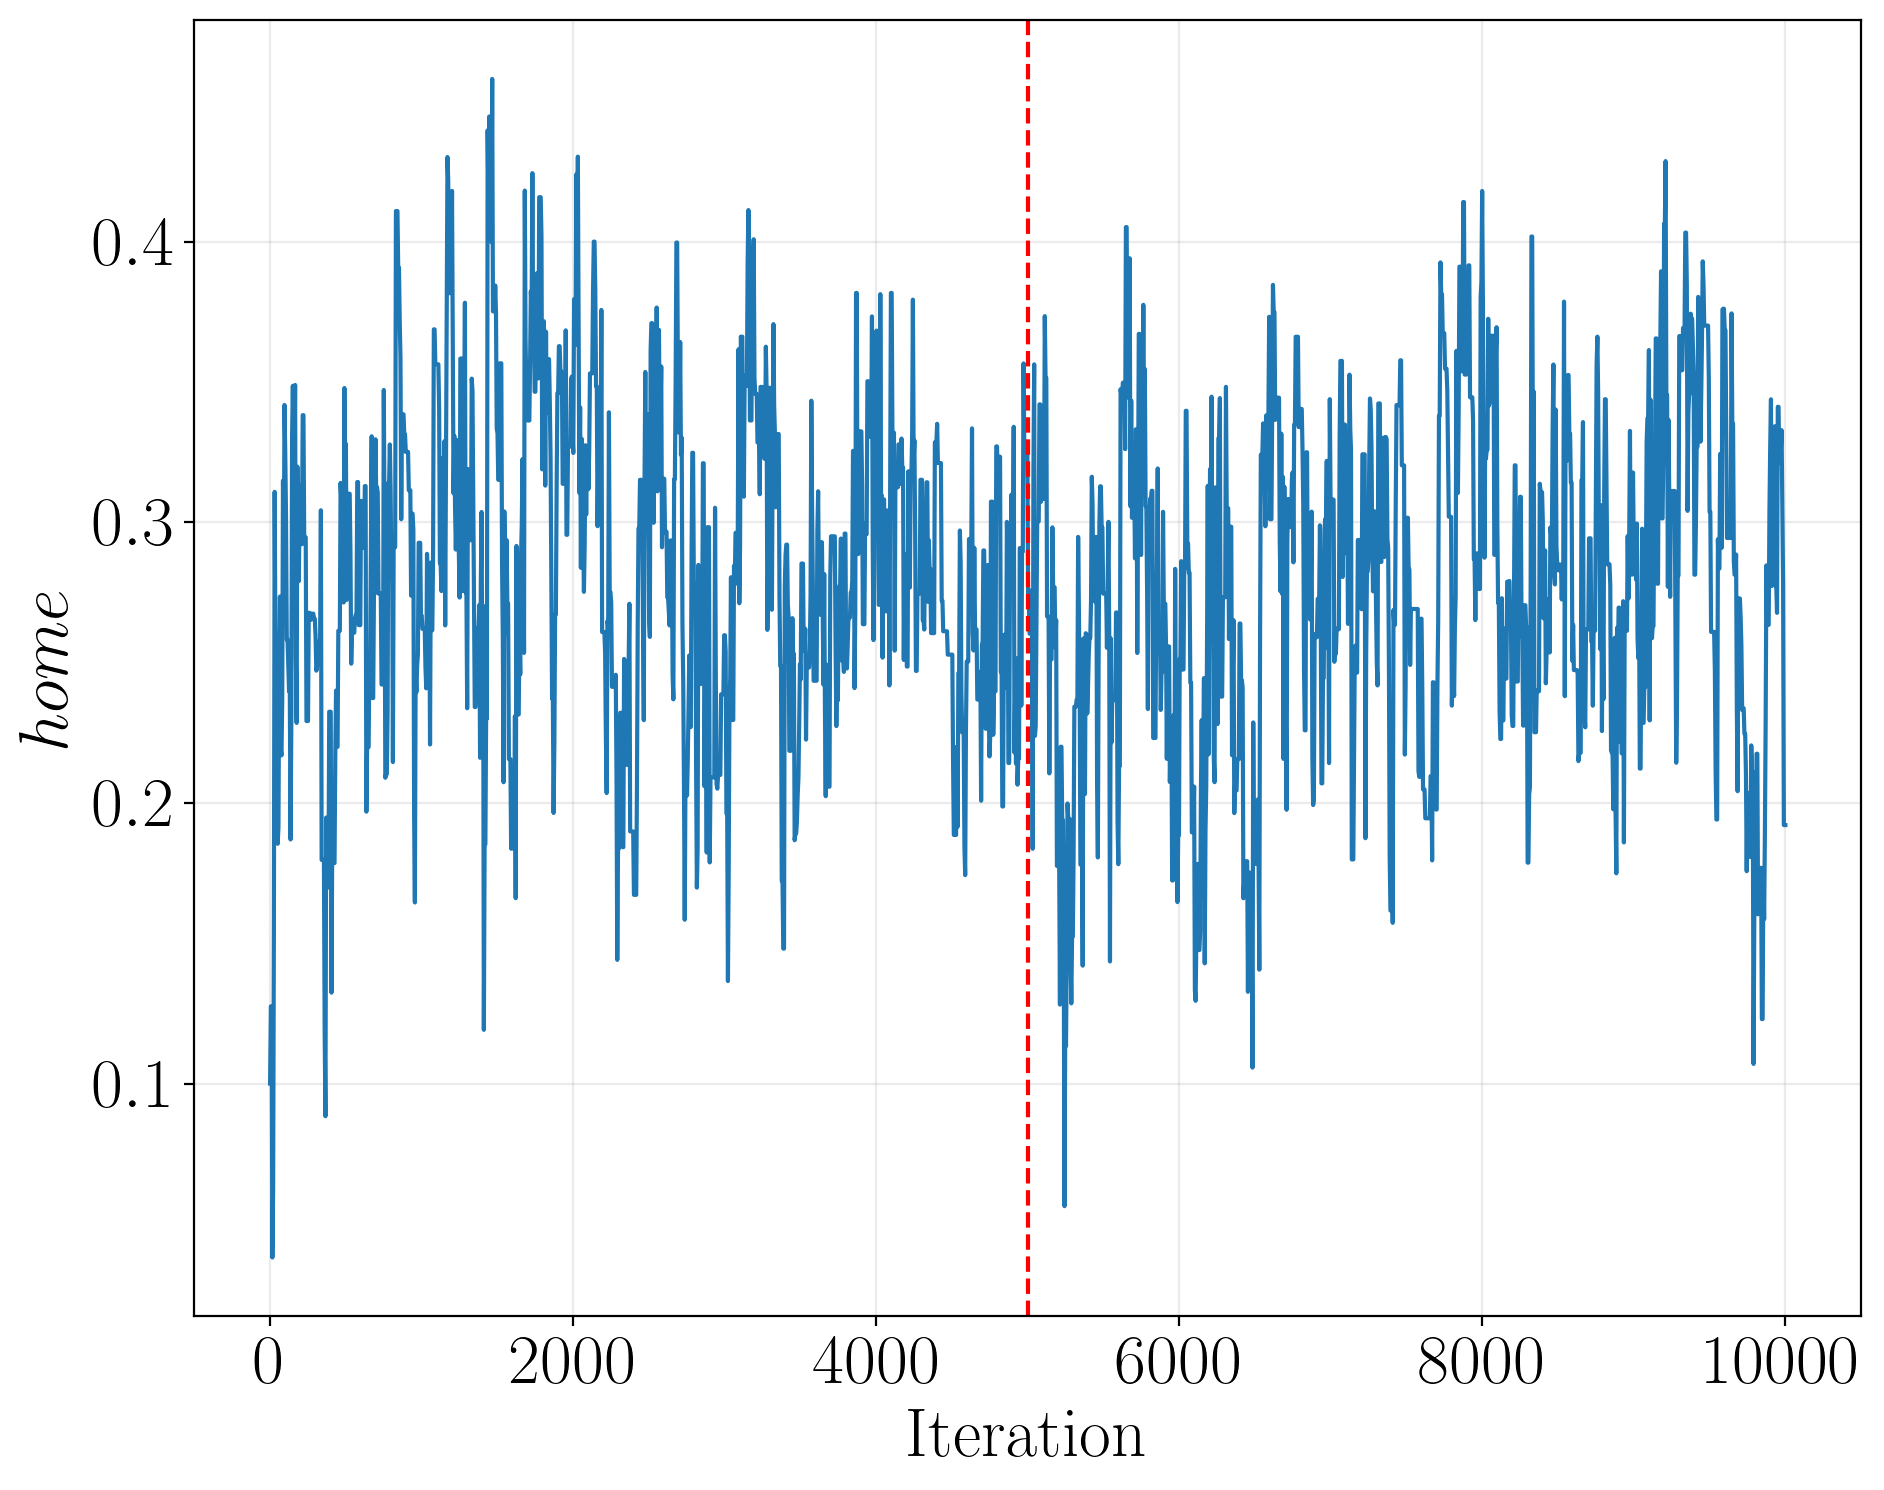

Rejection rate: sigma=0.05, thinning=5: 0.8158


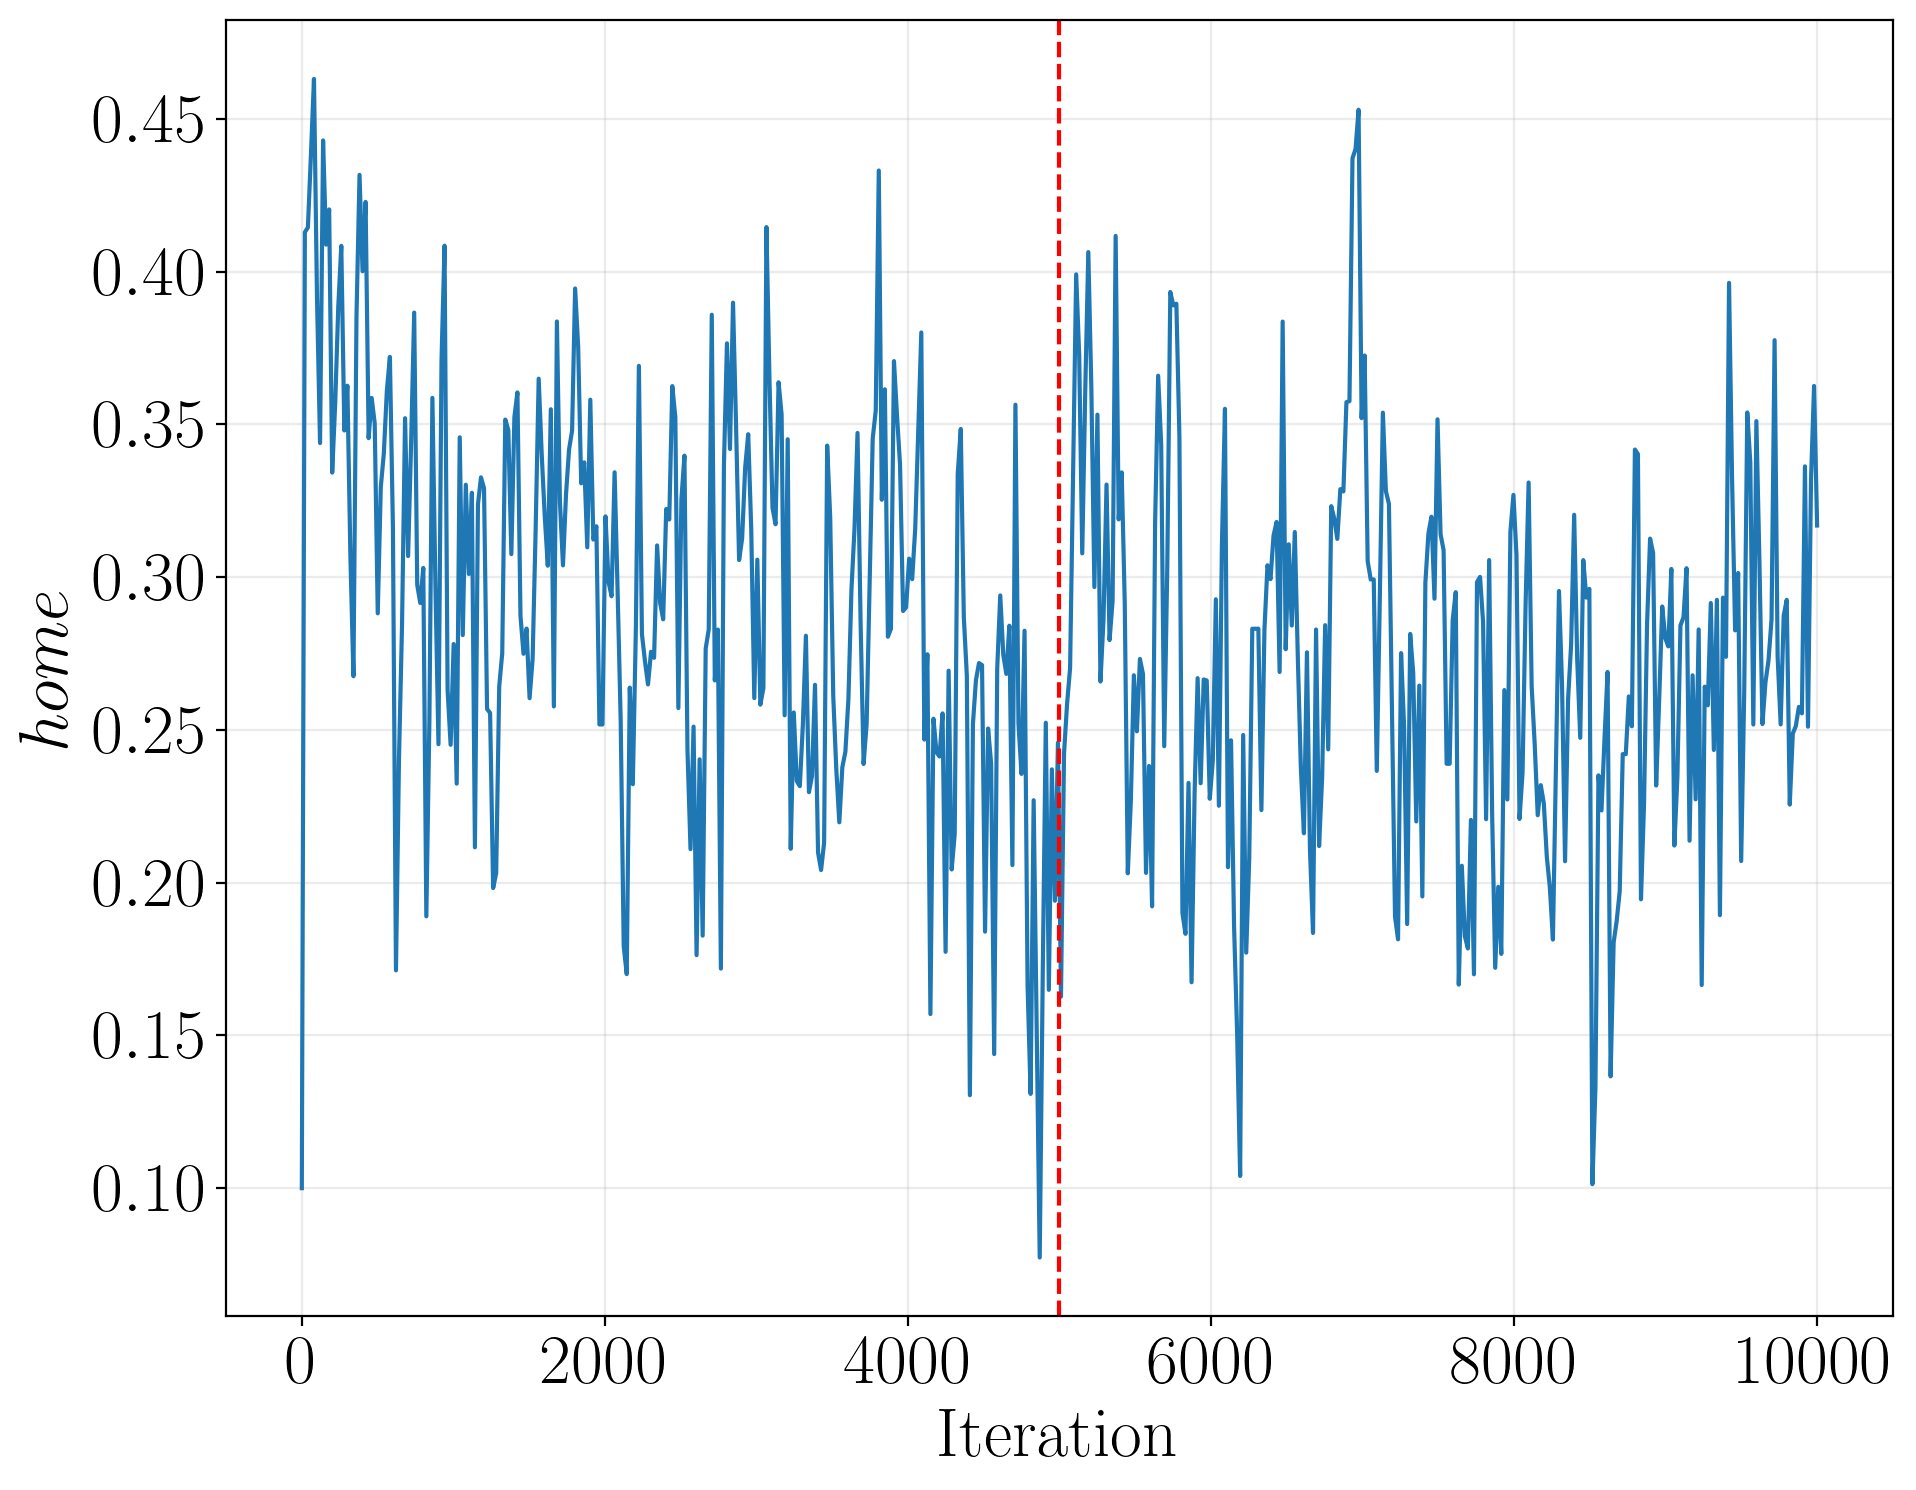

Rejection rate: sigma=0.05, thinning=20: 0.827


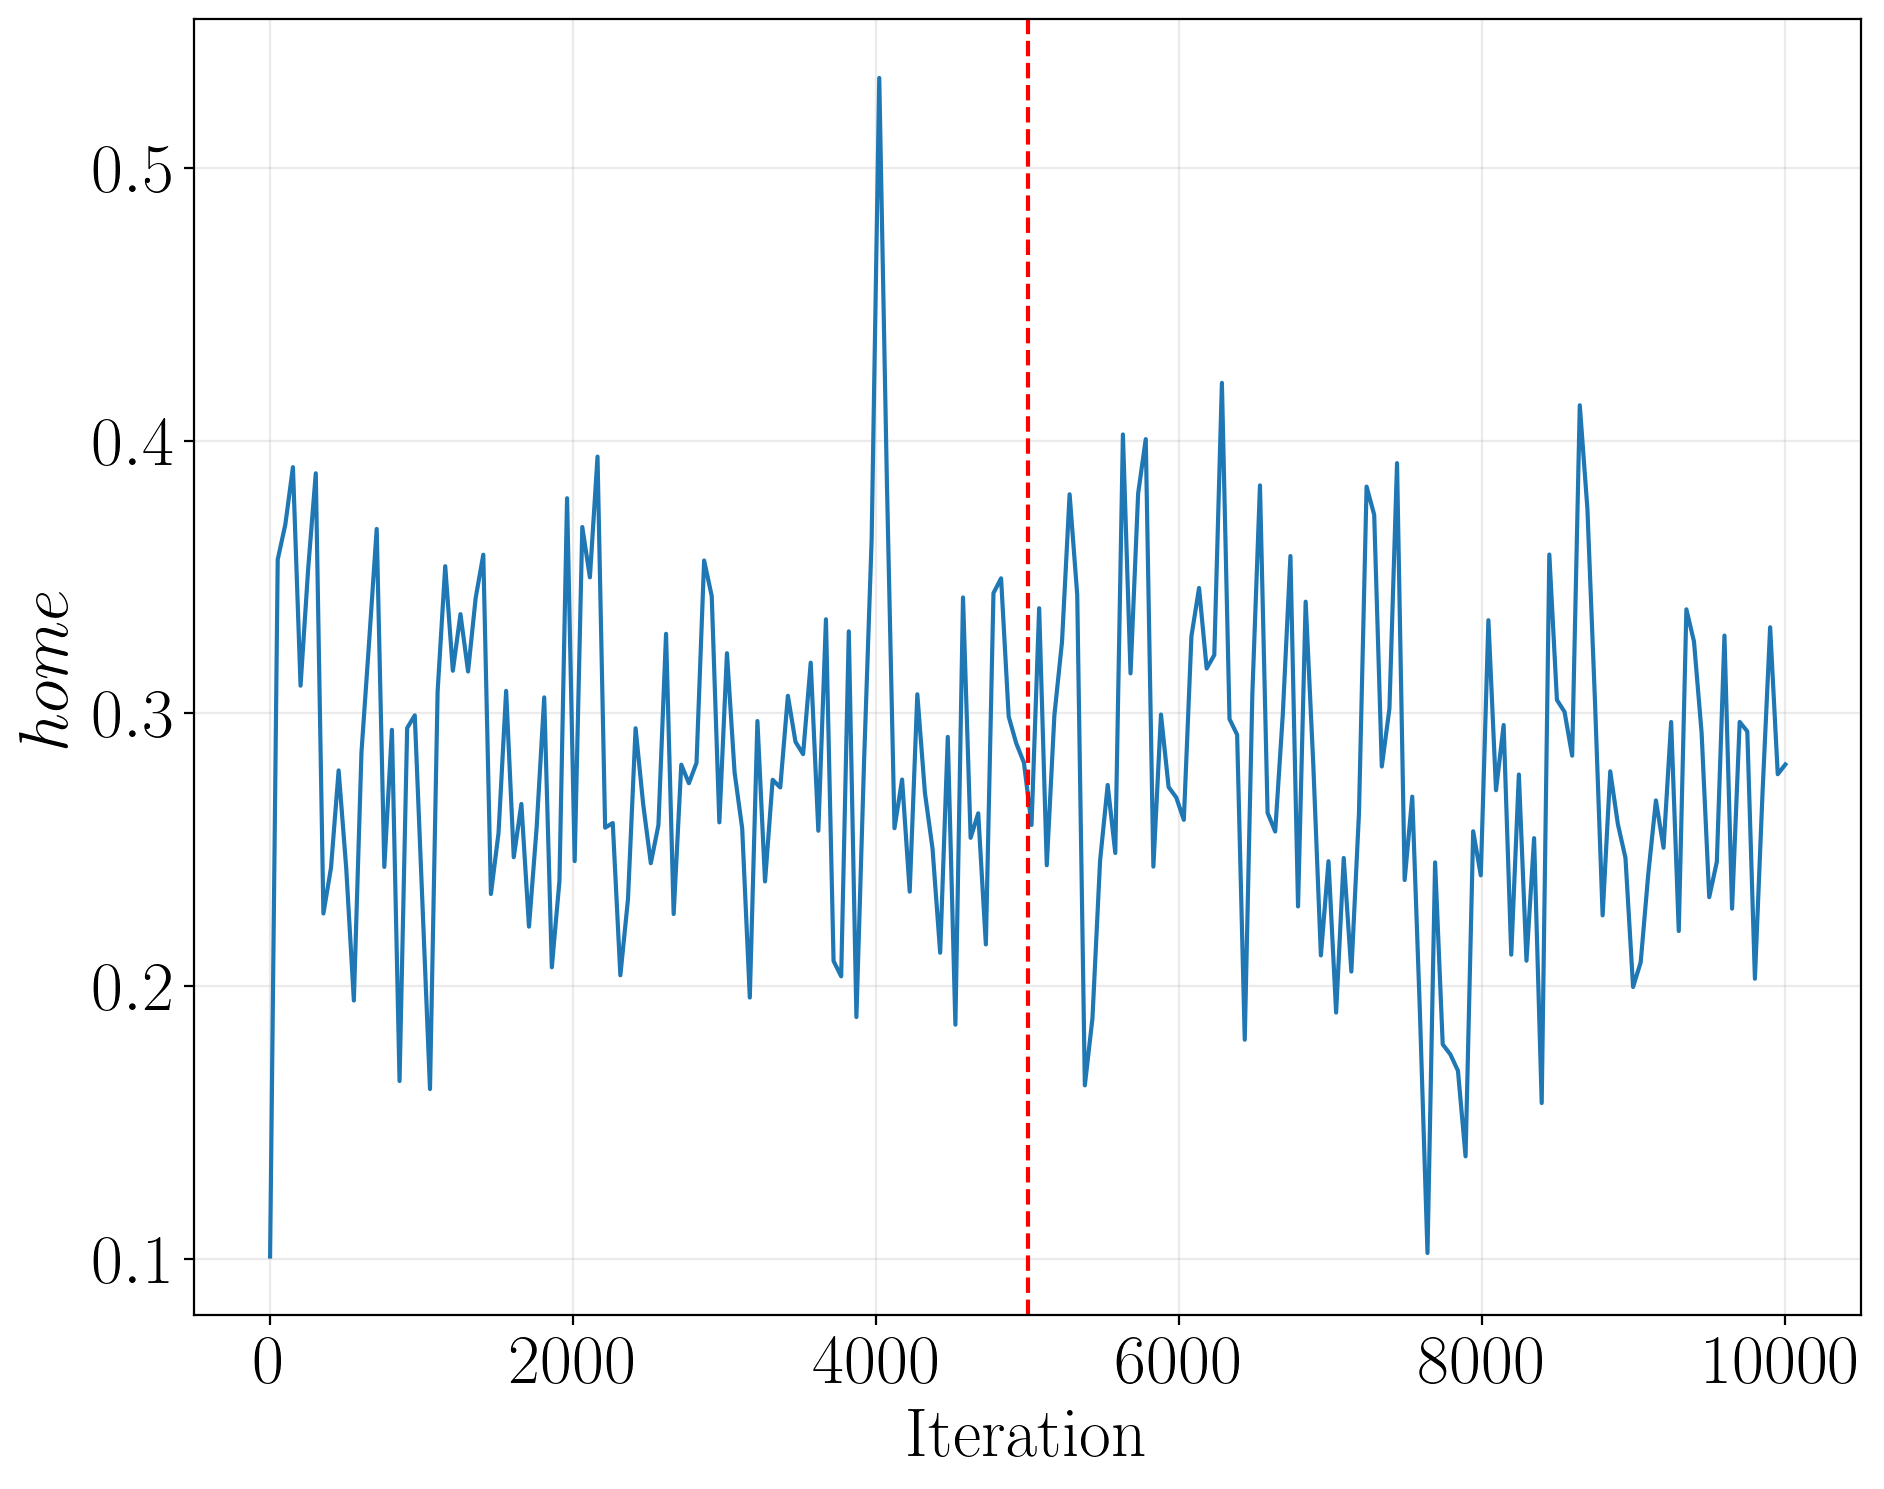

Rejection rate: sigma=0.05, thinning=50: 0.8299


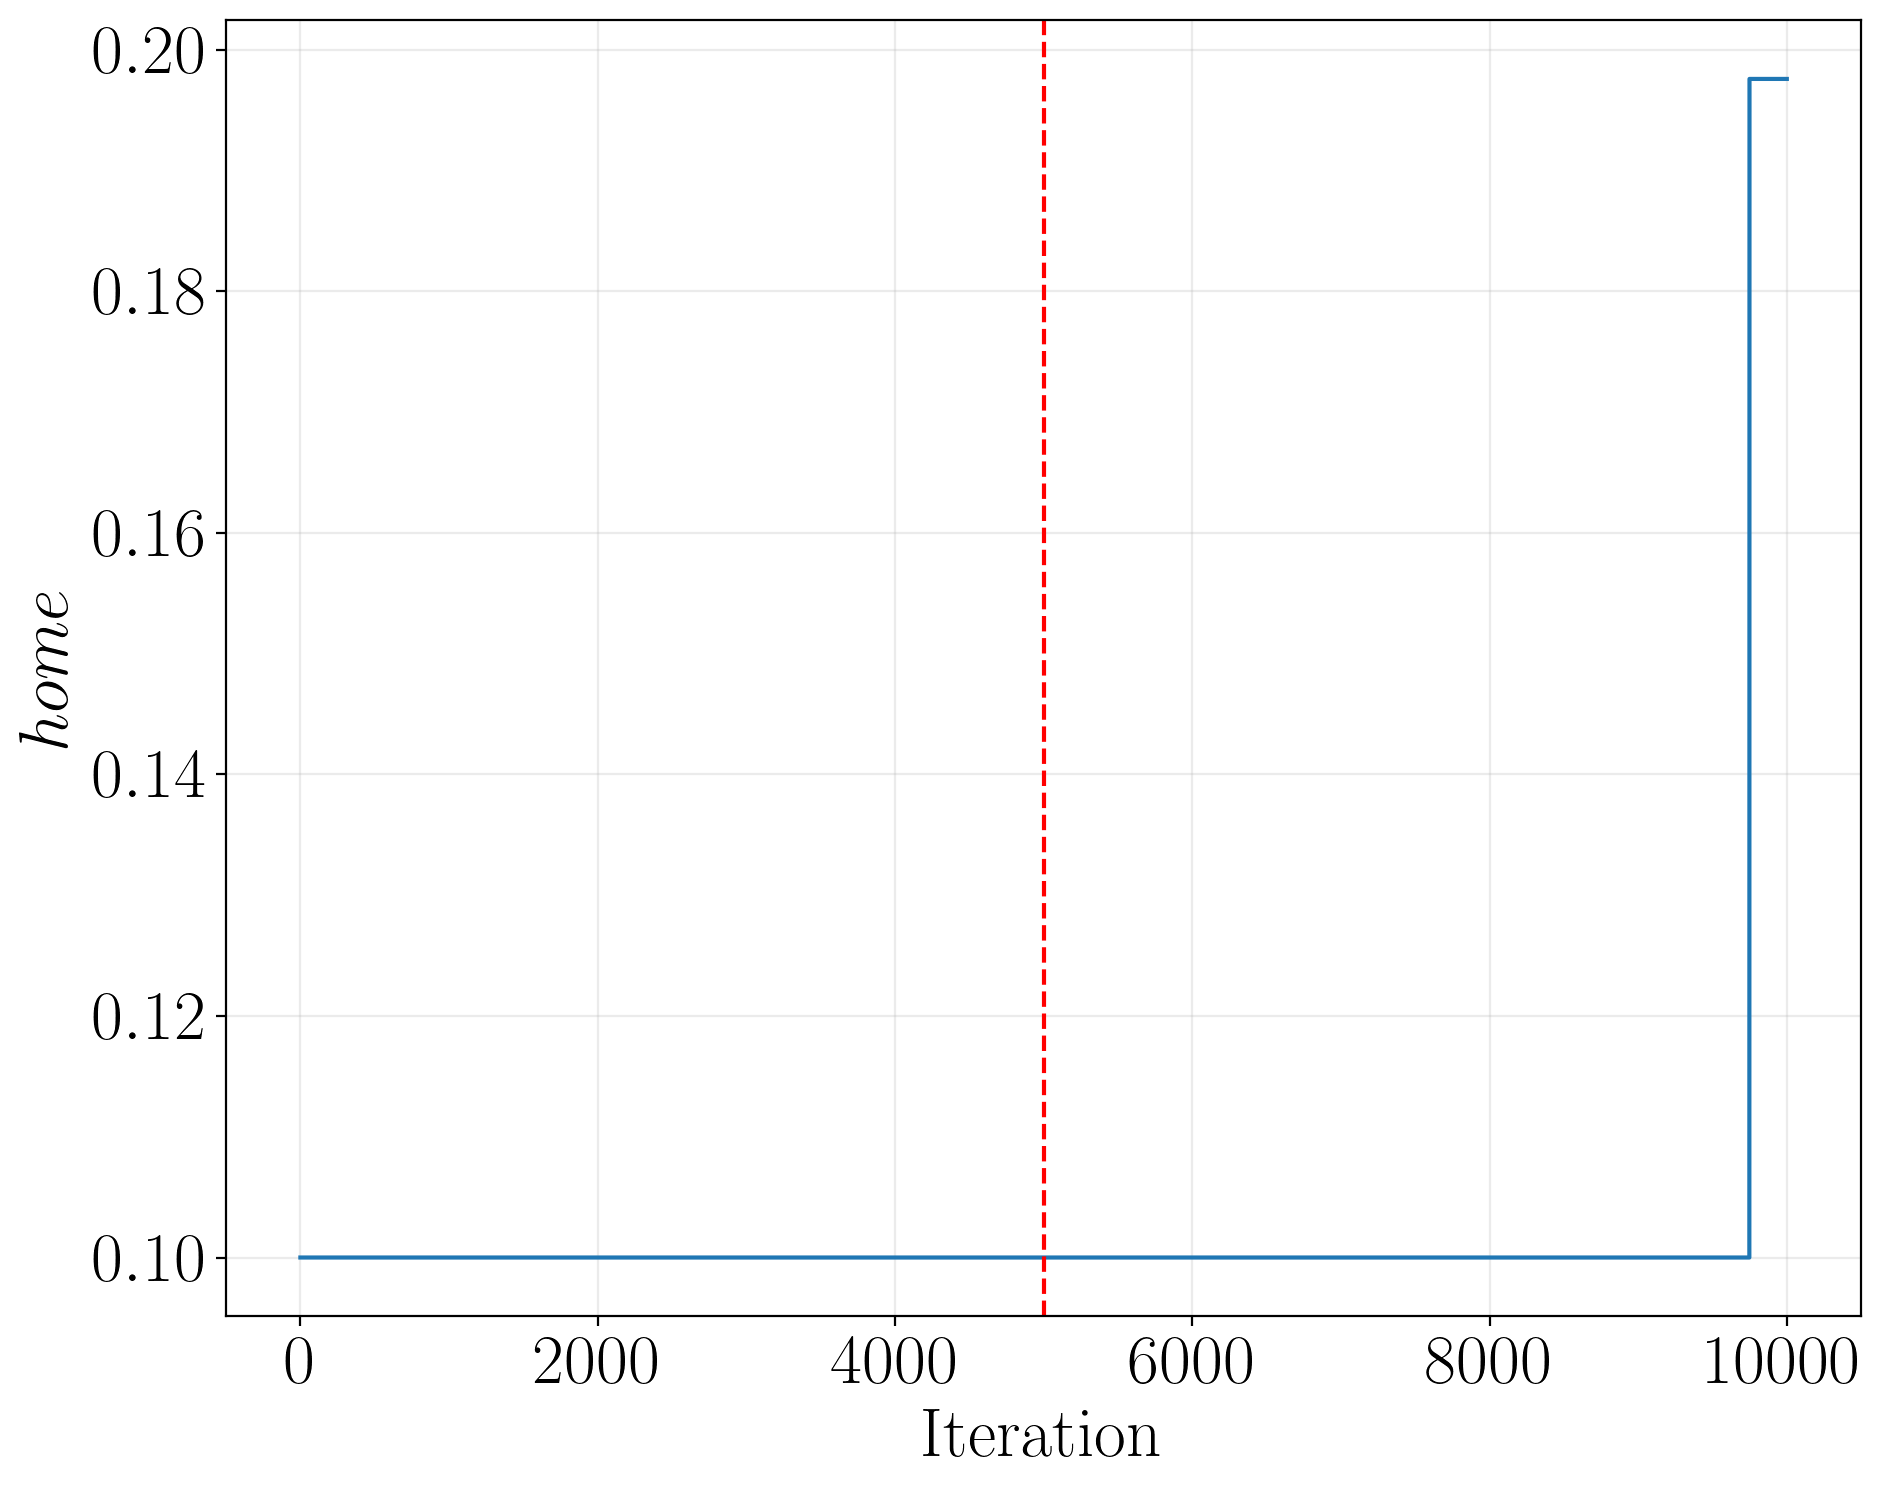

Rejection rate: sigma=0.5, thinning=1: 0.9998


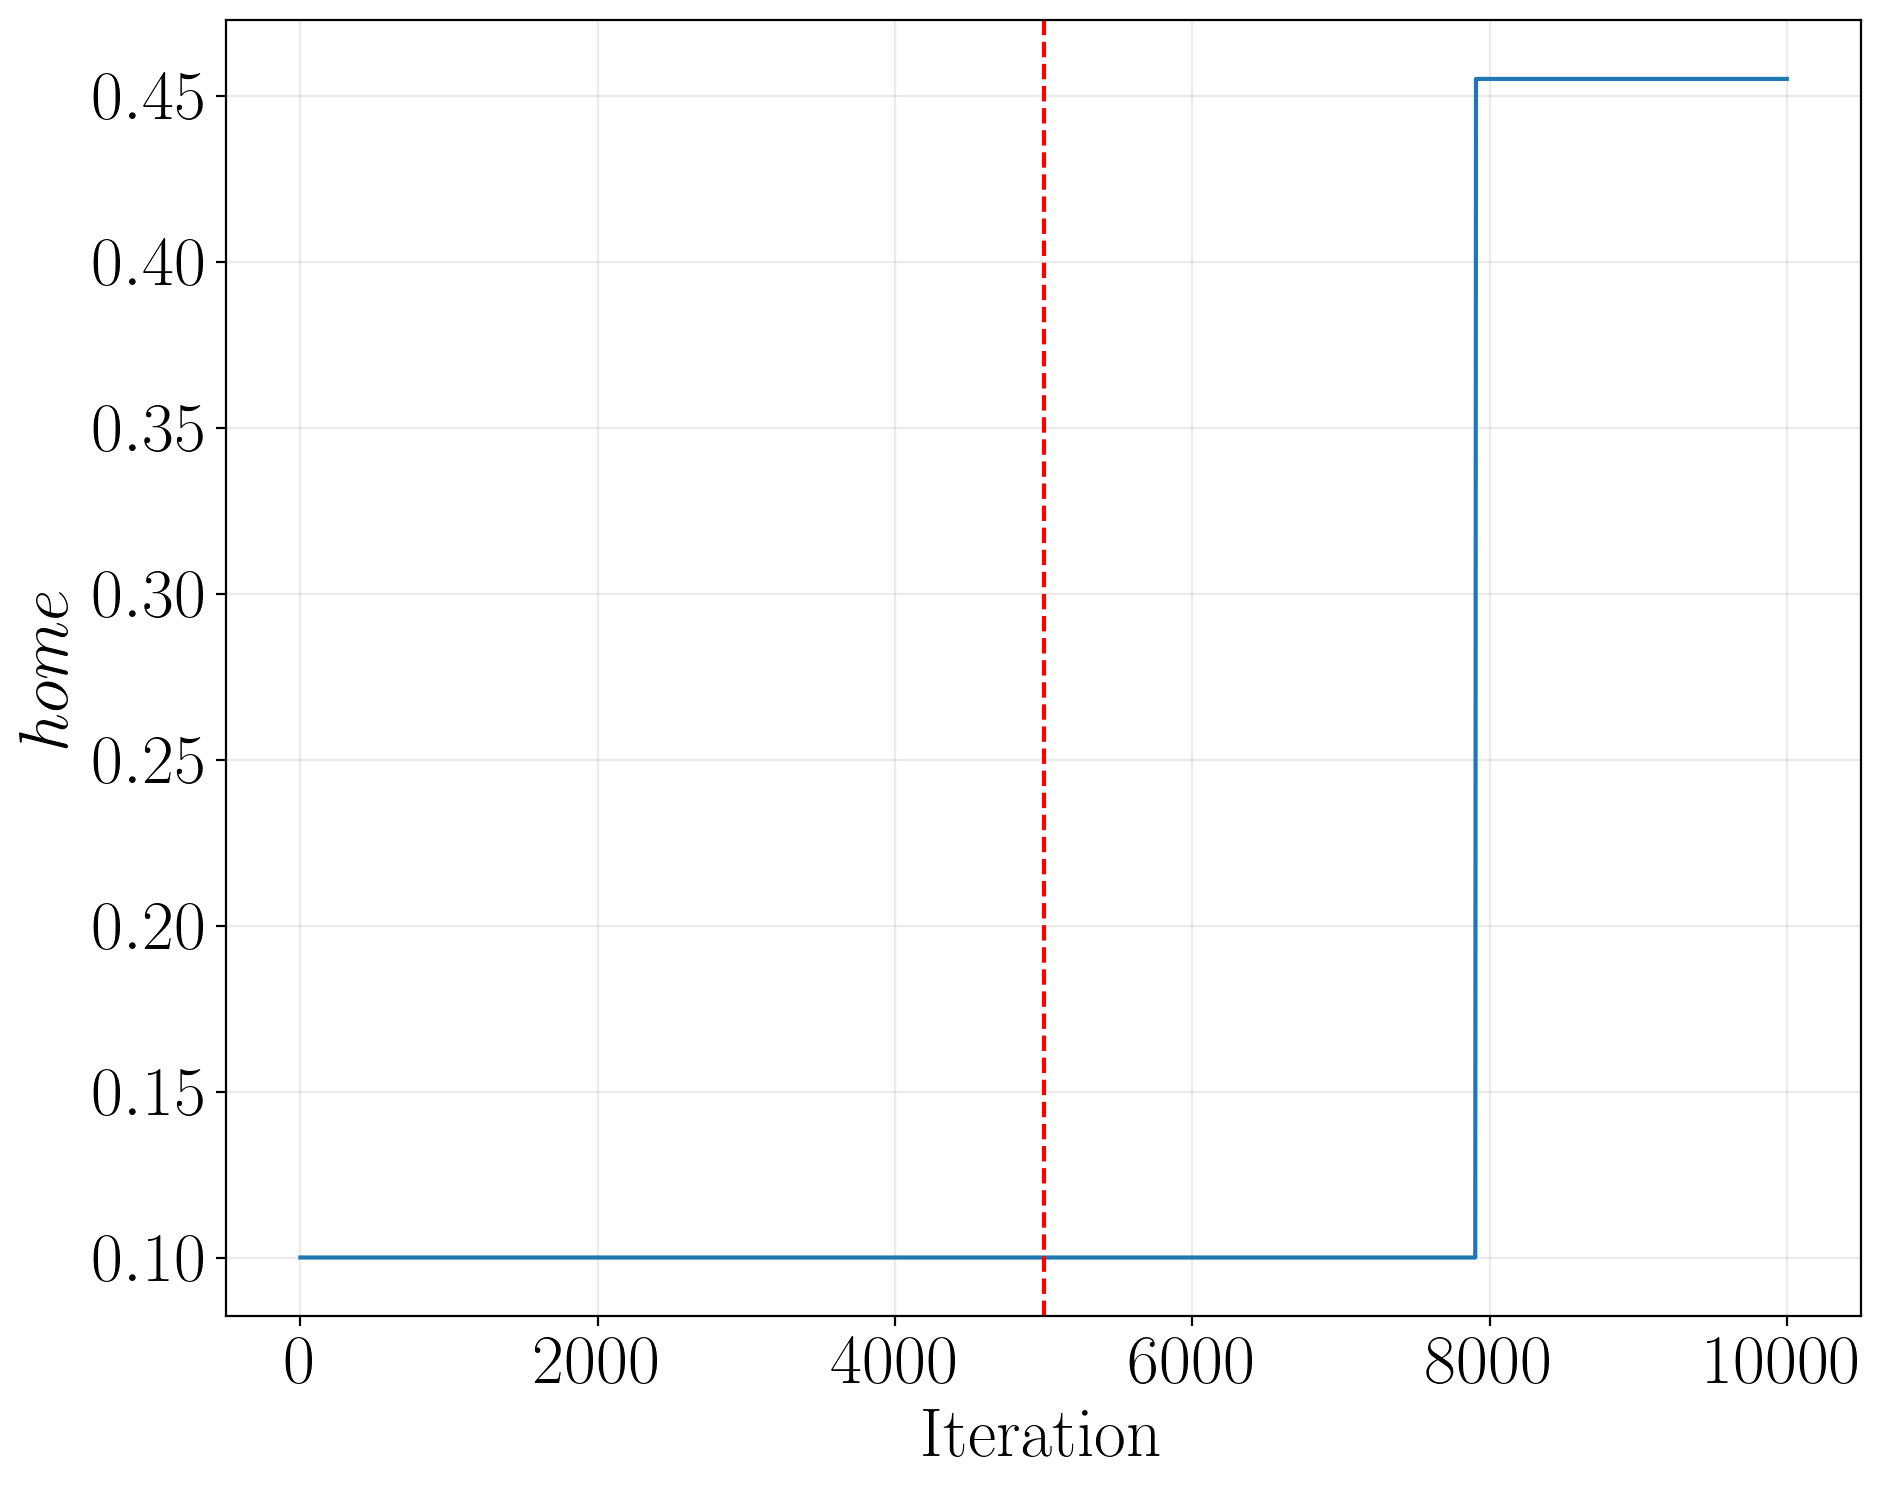

Rejection rate: sigma=0.5, thinning=5: 0.9999


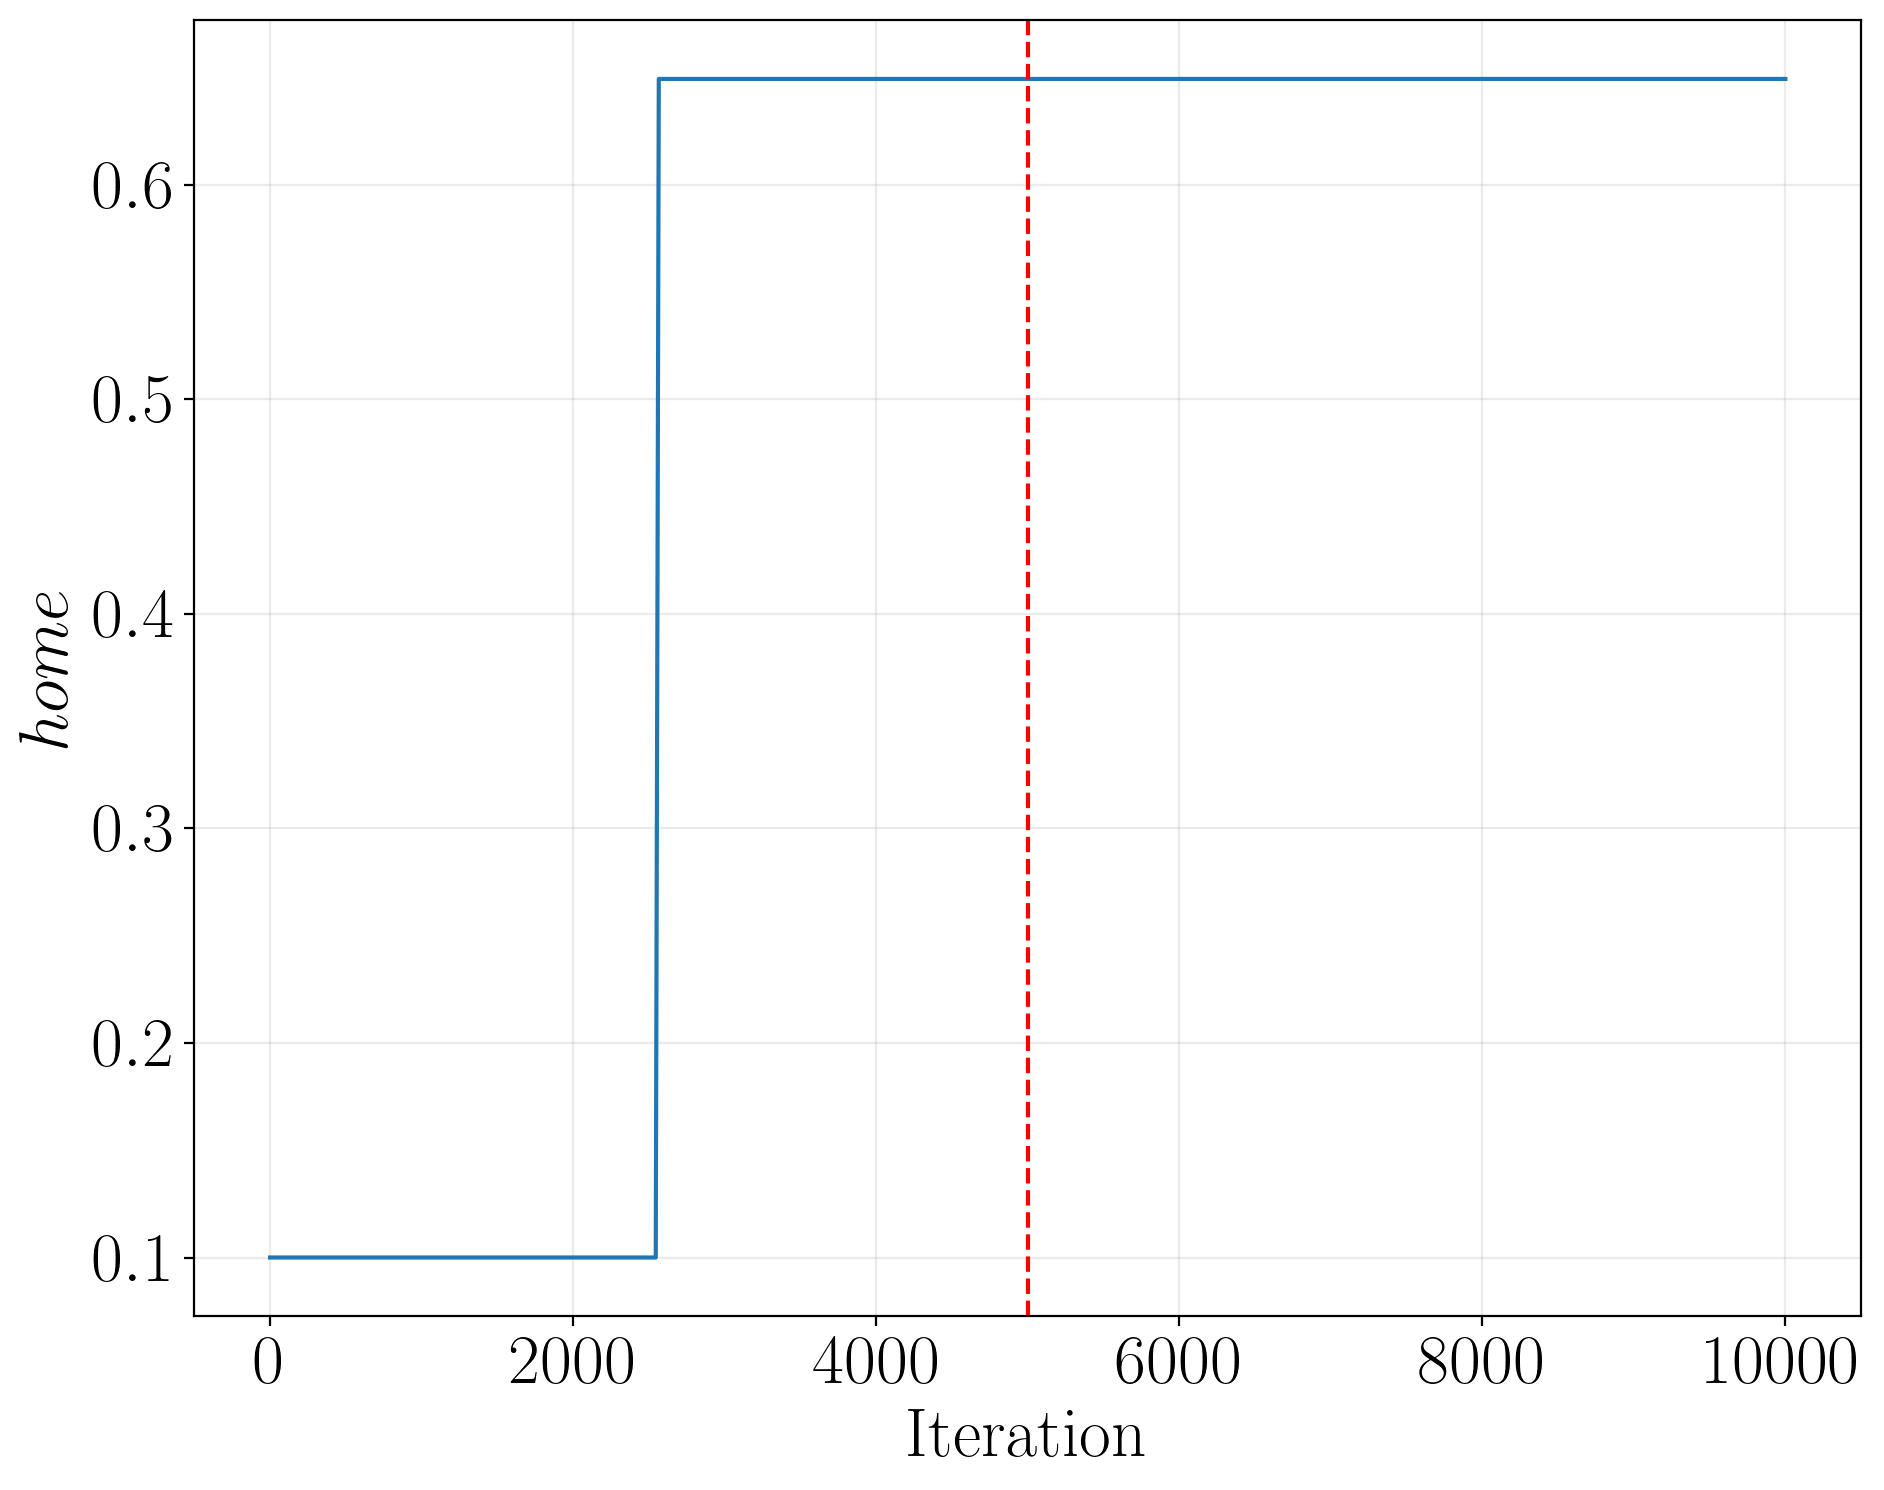

Rejection rate: sigma=0.5, thinning=20: 1.0


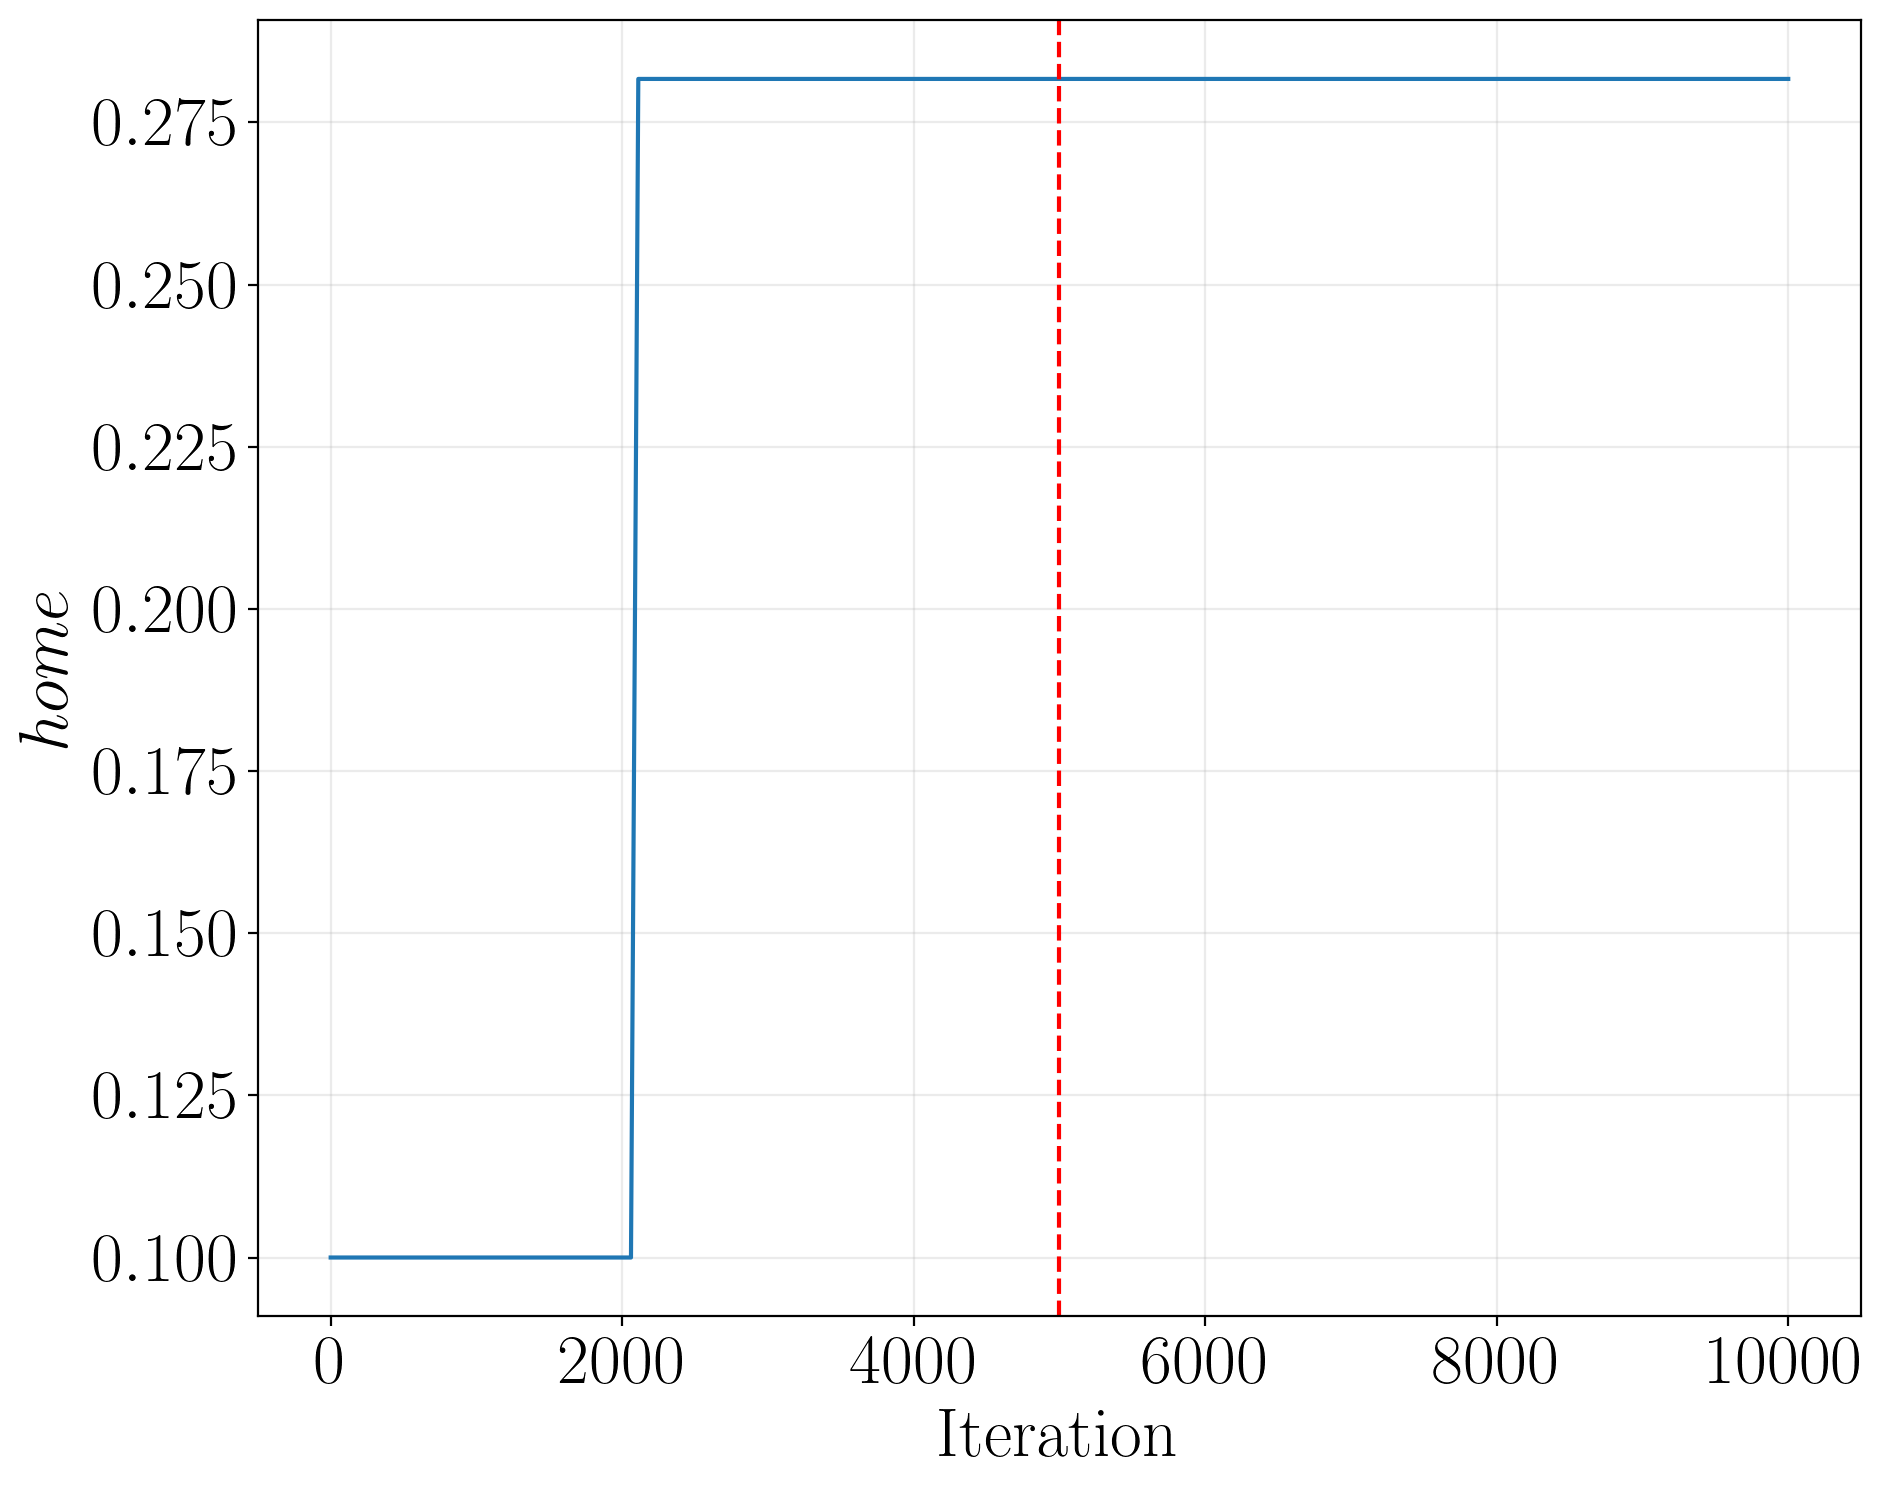

Rejection rate: sigma=0.5, thinning=50: 1.0


In [64]:
plot_its = burn_in + n_samples
t = 0
for i in range(len(sigmas)):
    for j in range(len(thinning)):

        rejection = np.load(f'samples/rejection_sigma={sigmas[i]}_thinning={thinning[j]}.npy')
        # rejection = rejection_batches[t]
        # rejection = rejection[burn_in:]
        print(f'Rejection rate: sigma={sigmas[i]}, thinning={thinning[j]}:', np.round(np.mean(rejection), 4))

        home = np.load(f'samples/home_sigma={sigmas[i]}_thinning={thinning[j]}.npy')
        plot_samples = plot_its//thinning[j]
        its = np.array(np.linspace(0,plot_its,plot_samples))
        home = home_batches[t]

        fig = plt.figure()
        ax = plt.axes()
        ax.plot(its, home[:plot_samples], '-')
        # ax.plot(np.array(np.linspace(0,n_homes*thinning[j],n_homes)), home, '-')
        ax.axvline(x=burn_in, color='red', linestyle='--', label='Burn-in')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('$home$')
        ax.grid(True, alpha=0.25)
        fig.tight_layout()
        fig.savefig(f'report-images/home_sigma={sigmas[i]}_thinning={thinning[j]}.png', dpi=300)
        plt.show()

        t += 1

In [63]:
t = 0
for i in range(len(sigmas)):
    for j in range(len(thinning)):
        rejection = np.load(f'samples/rejection_sigma={sigmas[i]}_thinning={thinning[j]}.npy')
        # rejection = rejection_batches[t]
        # rejection = rejection[burn_in:]
        print(f'Rejection rate: sigma={sigmas[i]}, thinning={thinning[j]}:', np.round(np.mean(rejection), 4))
        t += 1

Rejection rate: sigma=0.005, thinning=1: 0.108
Rejection rate: sigma=0.005, thinning=5: 0.0995
Rejection rate: sigma=0.005, thinning=20: 0.1039
Rejection rate: sigma=0.005, thinning=50: 0.1038
Rejection rate: sigma=0.05, thinning=1: 0.8196
Rejection rate: sigma=0.05, thinning=5: 0.8158
Rejection rate: sigma=0.05, thinning=20: 0.827
Rejection rate: sigma=0.05, thinning=50: 0.8299
Rejection rate: sigma=0.5, thinning=1: 0.9998
Rejection rate: sigma=0.5, thinning=5: 0.9999
Rejection rate: sigma=0.5, thinning=20: 1.0
Rejection rate: sigma=0.5, thinning=50: 1.0


In [43]:
samples, _ = metropolis_hastings(n_samples, n_teams, sigmas[1], dataf, thinning[1], burn_in, sample_burn_in=False)
homes = samples[:,-1]

0 / 5000 samples

C:\Users\erikn\AppData\Local\Temp\ipykernel_2004\1881268469.py:35: RuntimeWarning: invalid value encountered in sqrt
  attack_logprob = st.norm(mu_attack, 1/np.sqrt(tau_attack)).logpdf(attack)


5000 / 5000 samples

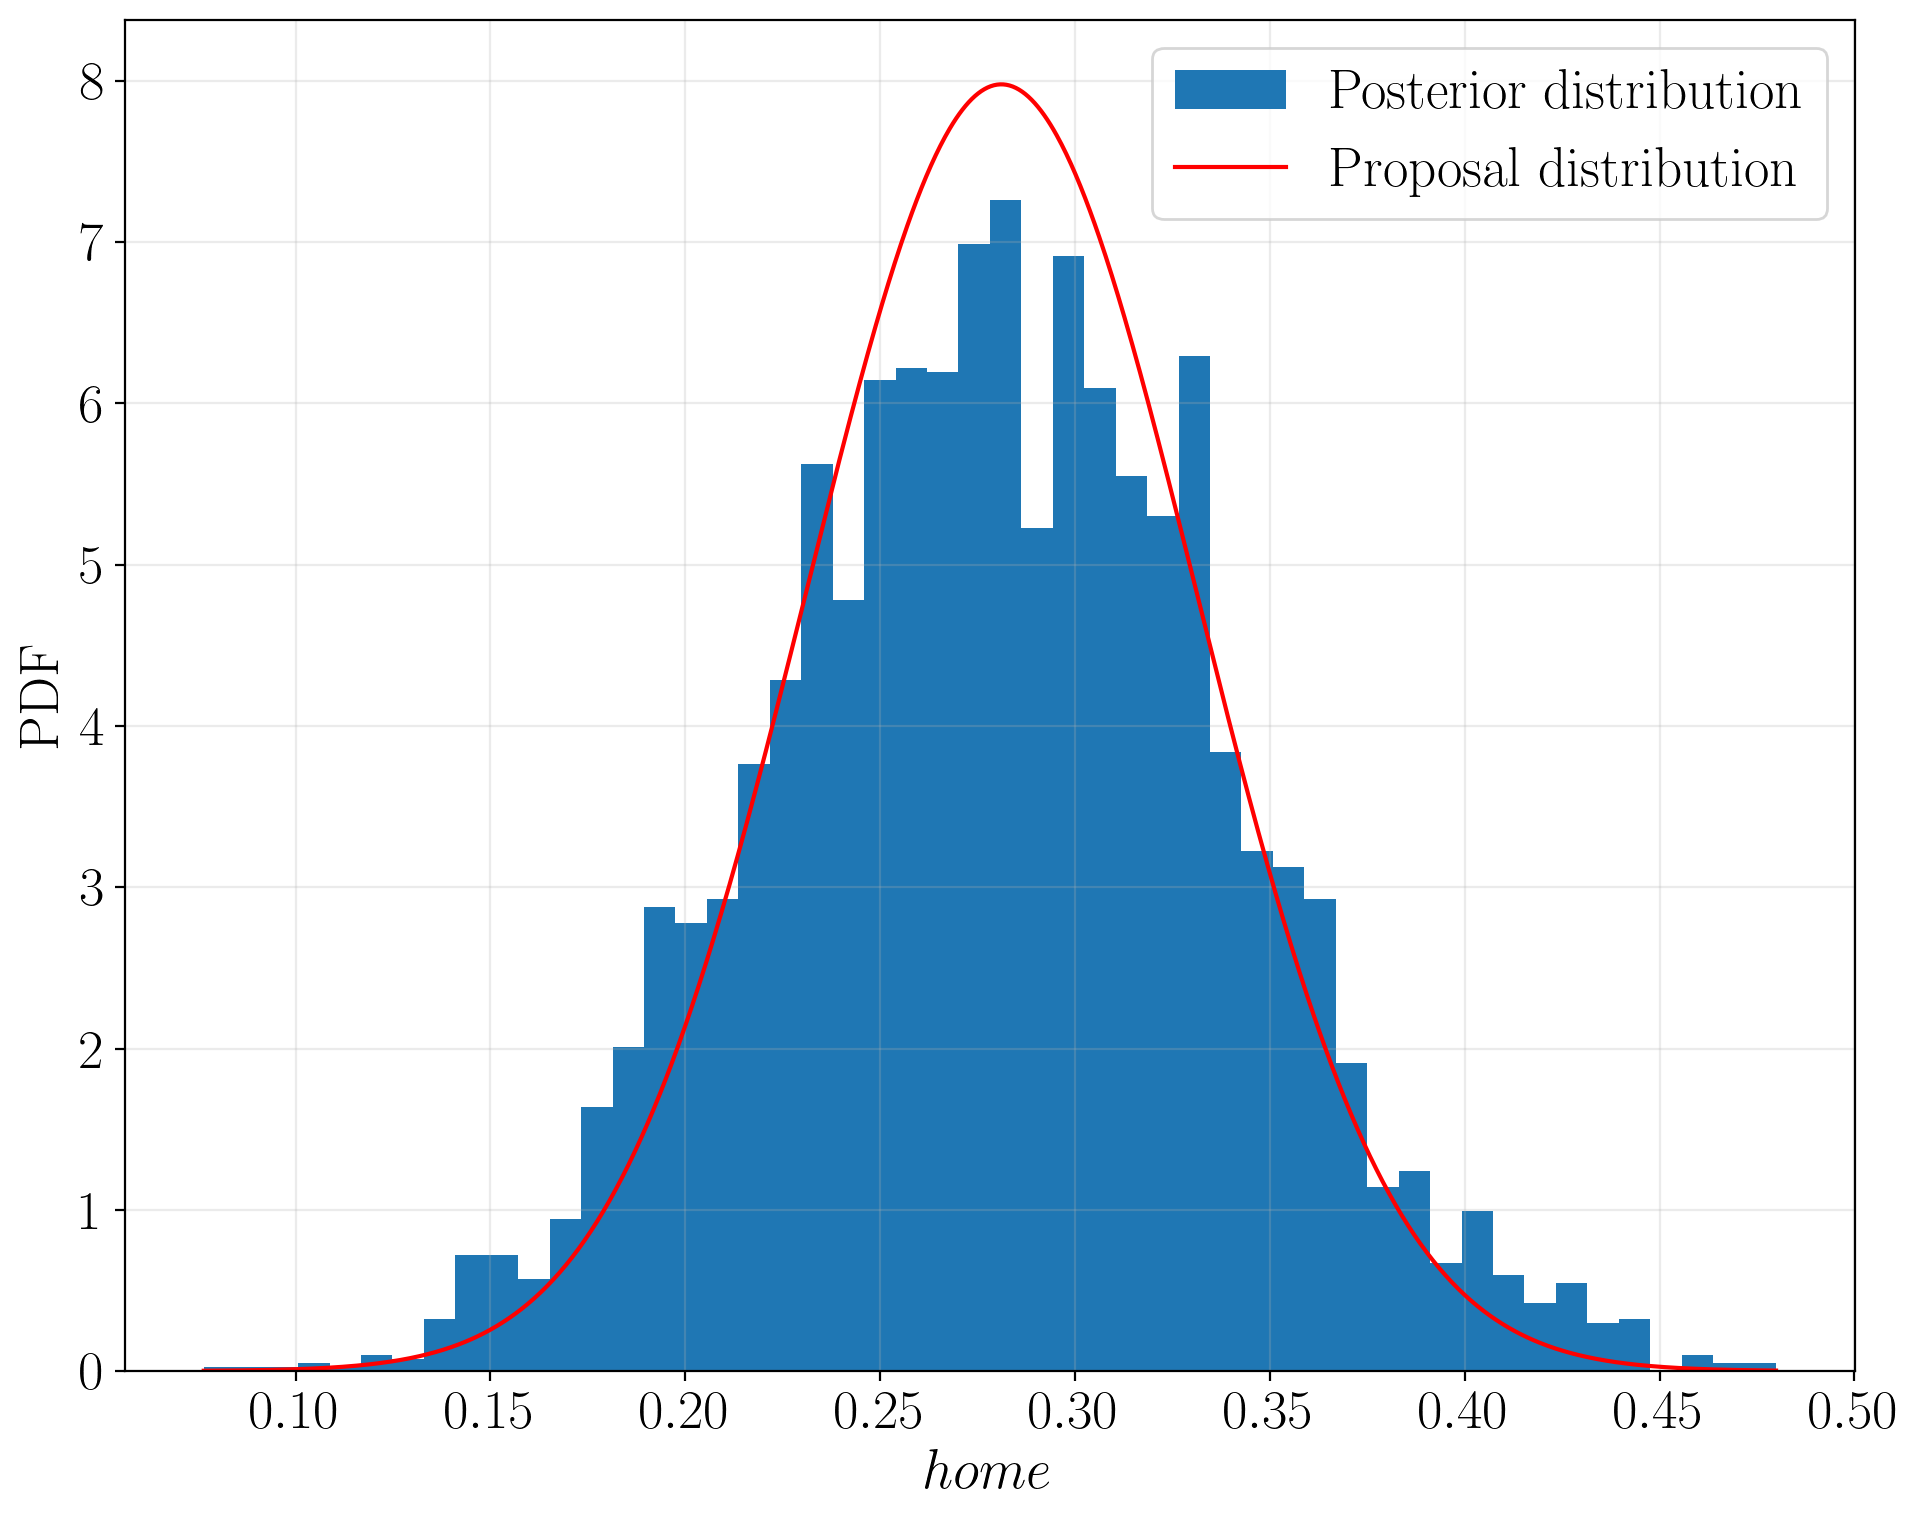

In [53]:
proposal_x = np.linspace(np.min(homes), np.max(homes), 1000)
proposal_y = st.norm(np.mean(homes), sigmas[1]).pdf(proposal_x)

fig = plt.figure()
plt.hist(homes, bins=50, density=True, label='Posterior distribution')
plt.plot(proposal_x, proposal_y, color='red', label='Proposal distribution')
plt.xlabel('$home$')
plt.ylabel('PDF')
plt.grid(True, alpha=0.25)
plt.legend()
fig.tight_layout()
fig.savefig(f'report-images/home_hist.png', dpi=300)
plt.show()

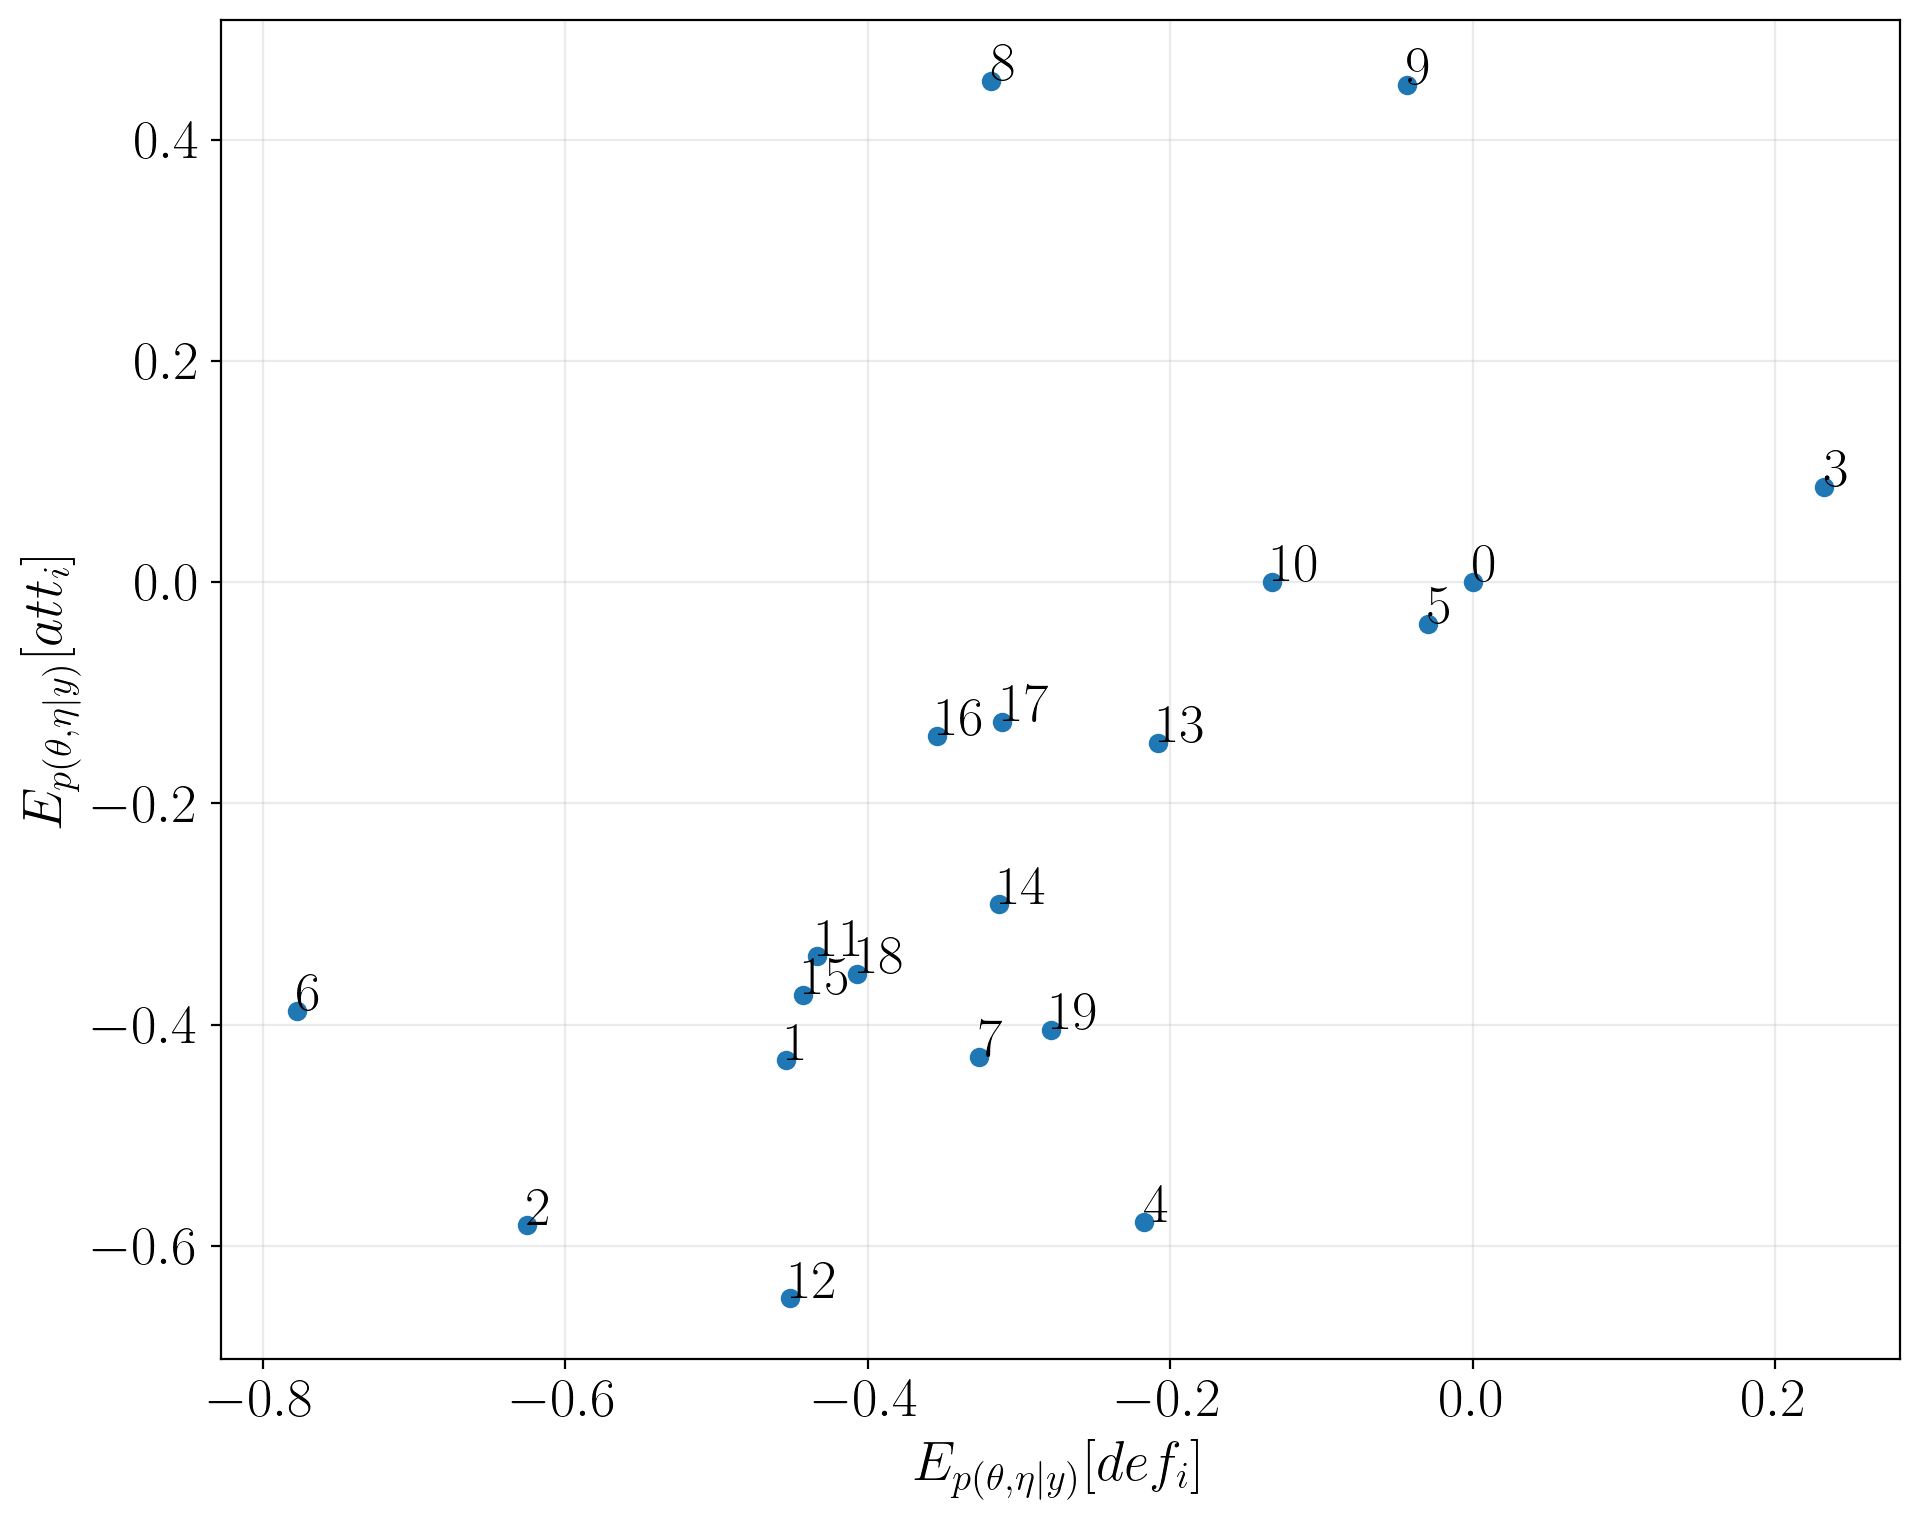

In [50]:
expected_attack = np.mean(samples[:,:n_teams], 0)
expected_defense = np.mean(samples[:,n_teams:-1], 0)

fig = plt.figure()
ax = plt.axes()
ax.plot(expected_defense, expected_attack, 'o')
for i in range(expected_defense.shape[0]):
    ax.text(expected_defense[i], expected_attack[i], str(i))
ax.set_xlabel(r'$E_{p(\theta,\eta\mid y)}[def_i]$')
ax.set_ylabel(r'$E_{p(\theta,\eta\mid y)}[att_i]$')
ax.grid(True, alpha=0.25)
fig.tight_layout()
fig.savefig(f'report-images/attack_vs_defense.png', dpi=300)
plt.show()